<a href="https://colab.research.google.com/github/DKS2301/GRU-MHA-RUL-Forecasting/blob/main/GRU_MHA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GRU-MHA: Implementation based on Aljohani & Aljohani (2025) Hybrid GRU-MHA model for accurate battery RUL forecasting with feature selection

In [25]:
# ================================================================================
# GRU-MHA: Implementation based on Aljohani & Aljohani (2025)
# Hybrid GRU-MHA model for accurate battery RUL forecasting with feature selection
# ================================================================================

from google.colab import drive
drive.mount('/content/drive', force_remount=False)

import os, time, warnings, random
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau

warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120
plt.rcParams['figure.figsize'] = [14, 6]

SEED = 42
def set_seed(seed=SEED):
    random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed); torch.backends.cudnn.deterministic = True
set_seed(SEED)

# ============================================================================
# CONFIGURATION
# ============================================================================
class Config:
    DATASET_ROOT = "/content/drive/MyDrive/NASA dataset"
    RESULTS_ROOT = "/content/drive/MyDrive/GRU_MHA_Results"
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Model hyperparameters from paper
    WINDOW_SIZE = 28  # Sequence length
    EOL_THRESHOLD = 0.80  # 80% capacity as mentioned in paper
    CORRELATION_THRESHOLD = 0.40  # 40% Pearson correlation threshold

    GRU_HIDDEN = 64
    GRU_LAYERS = 2
    MHA_HEADS = 8
    MHA_DIM = 64
    DENSE_HIDDEN = 30  # As mentioned in paper
    DROPOUT = 0.25

    # Training parameters
    BATCH_SIZE = 32
    EPOCHS = 250
    BASE_LR = 0.001  # As mentioned in paper (Nadam optimizer)
    WEIGHT_DECAY = 1e-4
    GRAD_CLIP = 1.0
    PATIENCE = 50

    # Loss weights (can be adjusted based on linear/non-linear behavior)
    ALPHA_RUL = 0.7
    BETA_SOH = 0.3

    # Battery configurations
    BATTERY_CONFIGS = {
        'NASA_B5B6B18B7': {'train': ['B0005', 'B0006', 'B0018'], 'test': 'B0007'},
        'NASA_B5B7B18B6': {'train': ['B0005', 'B0007', 'B0018'], 'test': 'B0006'},
        'NASA_B6B7B18B5': {'train': ['B0006', 'B0007', 'B0018'], 'test': 'B0005'},
    }

config = Config()
os.makedirs(config.RESULTS_ROOT, exist_ok=True)
print(f"Device: {config.DEVICE}")
print(f"Results will be saved to: {config.RESULTS_ROOT}")

# ============================================================================
# DATA LOADING & FEATURE ENGINEERING
# ============================================================================
class BatteryDataLoader:
    def __init__(self, eol_threshold=0.80):
        self.eol_threshold = eol_threshold

    def load_battery(self, path):
        """Load battery data from CSV"""
        df = pd.read_csv(path)
        return {
            'cycle': df['cycle'].values,
            'capacity': df['capacity'].values,
            'voltage': df['voltage_battery'].values,
            'current': df['current_battery'].values,
            'temp': df['temp_battery'].values,
            'time': df['time'].values if 'time' in df.columns else np.arange(len(df))
        }

    def compute_eol(self, capacities):
        """Compute End of Life cycle"""
        C0 = capacities.max()
        eol_threshold = self.eol_threshold * C0
        eol_idx = np.where(capacities <= eol_threshold)[0]
        return int(eol_idx[0]) if len(eol_idx) > 0 else len(capacities) - 1

    def create_features(self, data):
        """
        Create comprehensive feature set as described in the paper
        Features include: capacity, voltage, current, temperature,
        normalized capacity, gradients, moving averages, etc.
        """
        n = len(data['cycle'])
        cap = data['capacity']
        volt = data['voltage']
        curr = data['current']
        temp = data['temp']
        time_val = data['time']

        C0 = cap[0]  # Initial capacity

        features = []

        # 1. Raw features
        features.append(cap)
        features.append(volt)
        features.append(curr)
        features.append(temp)
        features.append(time_val)

        # 2. Normalized capacity (SOH)
        features.append(cap / C0)

        # 3. Capacity degradation features
        features.append(C0 - cap)  # Capacity fade
        features.append(np.gradient(cap))  # First derivative
        features.append(np.gradient(np.gradient(cap)))  # Second derivative

        # 4. Statistical features
        features.append(pd.Series(cap).rolling(3, min_periods=1).mean().fillna(0).values)
        features.append(pd.Series(cap).rolling(5, min_periods=1).mean().fillna(0).values)
        features.append(pd.Series(cap).rolling(5, min_periods=1).std().fillna(0).values)

        # 5. Energy-related features
        features.append(volt * curr)  # Power
        features.append(volt / (cap + 1e-8))  # Voltage per capacity
        features.append(curr / (cap + 1e-8))  # Current per capacity

        # 6. Temperature features
        features.append(temp - np.mean(temp))  # Temperature deviation

        # 7. Cycle-based features
        features.append(np.arange(n) / max(n-1, 1))  # Normalized cycle index

        # 8. Signal energy (as mentioned in paper)
        features.append(np.cumsum(volt**2))

        # 9. Fluctuation index
        features.append(np.abs(np.gradient(cap)) / (np.abs(cap) + 1e-8))

        # Stack all features
        X = np.column_stack(features).astype(np.float32)
        return np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

    def separate_features(self, X, y):
        """
        Separate features into correlated and uncorrelated based on Pearson correlation
        Correlation threshold: 0.40 (40%) as mentioned in paper
        """
        n_features = X.shape[-1]

        # For sequence data, use the last timestep for correlation analysis
        if len(X.shape) == 3:
            X_flat = X[:, -1, :]
        else:
            X_flat = X

        correlations = []
        for i in range(n_features):
            try:
                corr, _ = pearsonr(X_flat[:, i], y)
                correlations.append(abs(corr))
            except:
                correlations.append(0.0)

        correlations = np.array(correlations)

        # Separate based on threshold
        correlated_idx = np.where(correlations >= config.CORRELATION_THRESHOLD)[0]
        uncorrelated_idx = np.where(correlations < config.CORRELATION_THRESHOLD)[0]

        print(f"  Correlated features ({len(correlated_idx)}): {correlated_idx}")
        print(f"  Uncorrelated features ({len(uncorrelated_idx)}): {uncorrelated_idx}")

        return correlated_idx, uncorrelated_idx, correlations

    def create_sequences(self, data, window_size):
        """Create sequences for time series prediction"""
        X = self.create_features(data)
        cap = data['capacity']
        eol = self.compute_eol(cap)

        n = len(cap)
        C0 = cap[0]

        if n < window_size + 5:
            return None, None, None

        # Create sequences
        X_seq = []
        y_rul = []
        y_soh = []

        for i in range(n - window_size + 1):
            X_seq.append(X[i:i+window_size])
            y_rul.append(max(0, eol - (i + window_size - 1)))
            y_soh.append(cap[i + window_size - 1] / C0)

        return (np.array(X_seq, dtype=np.float32),
                np.array(y_rul, dtype=np.float32),
                np.array(y_soh, dtype=np.float32))

class BatteryDataset(Dataset):
    def __init__(self, X, y_rul, y_soh, corr_idx, uncorr_idx):
        self.X = torch.FloatTensor(X)
        self.y_rul = torch.FloatTensor(y_rul)
        self.y_soh = torch.FloatTensor(y_soh)
        self.corr_idx = corr_idx
        self.uncorr_idx = uncorr_idx

    def __len__(self):
        return len(self.y_rul)

    def __getitem__(self, idx):
        x = self.X[idx]
        x_corr = x[:, self.corr_idx] if len(self.corr_idx) > 0 else torch.zeros(x.size(0), 1)
        x_uncorr = x[:, self.uncorr_idx] if len(self.uncorr_idx) > 0 else torch.zeros(x.size(0), 1)
        return x_corr, x_uncorr, self.y_rul[idx], self.y_soh[idx]

# ============================================================================
# GRU-MHA MODEL (Based on Paper Architecture)
# ============================================================================
class DynamicSwish(nn.Module):
    """Dynamic Swish activation as mentioned in paper"""
    def __init__(self, scale=1.0):
        super().__init__()
        self.scale = scale

    def forward(self, x):
        return x / (self.scale * (1 + torch.exp(-x)))

class MultiHeadAttention(nn.Module):
    """Multi-Head Attention layer with 8 heads as mentioned in paper"""
    def __init__(self, d_model, num_heads=8, dropout=0.1):
        super().__init__()
        assert d_model % num_heads == 0

        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads

        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(dropout)

    def scaled_dot_product_attention(self, Q, K, V):
        """Attention mechanism as defined in paper (Equations 6-10)"""
        scores = torch.matmul(Q, K.transpose(-2, -1)) / np.sqrt(self.d_k)
        attention_weights = F.softmax(scores, dim=-1)
        attention_weights = self.dropout(attention_weights)
        output = torch.matmul(attention_weights, V)
        return output, attention_weights

    def forward(self, x):
        batch_size, seq_len, d_model = x.size()

        # Linear projections
        Q = self.W_q(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        K = self.W_k(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2)
        V = self.W_v(x).view(batch_size, seq_len, self.num_heads, self.d_k).transpose(1, 2).contiguous()

        # Attention
        attn_output, attn_weights = self.scaled_dot_product_attention(Q, K, V)

        # Concatenate heads
        attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, seq_len, d_model)

        # Final linear projection
        output = self.W_o(attn_output)

        return output, attn_weights

class GRU_MHA_Model(nn.Module):
    """
    GRU-MHA Model as described in the paper (Figure 6)

    Architecture:
    1. Two-path input (correlated and uncorrelated features)
    2. GRU layers for temporal feature extraction
    3. Multi-Head Attention for feature emphasis
    4. Dense layers with dynamic swish activation
    5. Dual output heads (RUL and SOH)
    6. Ridge/Linear regression layer (implemented in training)
    """
    def __init__(self, n_corr_features, n_uncorr_features,
                 gru_hidden=64, gru_layers=2,
                 mha_heads=8, dense_hidden=30, dropout=0.25):
        super().__init__()

        self.n_corr = n_corr_features
        self.n_uncorr = n_uncorr_features

        # Path 1: Correlated features
        self.gru_corr = nn.GRU(
            input_size=max(n_corr_features, 1),
            hidden_size=gru_hidden,
            num_layers=gru_layers,
            batch_first=True,
            dropout=dropout if gru_layers > 1 else 0,
            bidirectional=False
        )

        # Path 2: Uncorrelated features through GRU
        self.gru_uncorr = nn.GRU(
            input_size=max(n_uncorr_features, 1),
            hidden_size=gru_hidden,
            num_layers=gru_layers,
            batch_first=True,
            dropout=dropout if gru_layers > 1 else 0,
            bidirectional=False
        )

        # Projection to MHA dimension
        combined_dim = gru_hidden * 2  # Two GRU paths
        self.projection = nn.Linear(combined_dim, mha_heads * 8)

        # Multi-Head Attention
        self.mha = MultiHeadAttention(
            d_model=mha_heads * 8,
            num_heads=mha_heads,
            dropout=dropout
        )

        # Dense layers (as mentioned in paper: 30 neurons)
        self.dense1 = nn.Linear(mha_heads * 8, dense_hidden)
        self.dropout1 = nn.Dropout(dropout)
        self.dense2 = nn.Linear(dense_hidden, dense_hidden)
        self.dropout2 = nn.Dropout(dropout)

        # Output heads
        self.rul_head = nn.Sequential(
            nn.Linear(dense_hidden, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 1)
        )

        self.soh_head = nn.Sequential(
            nn.Linear(dense_hidden, 16),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

        # Dynamic swish activation
        self.dynamic_swish = DynamicSwish(scale=1.0)

    def forward(self, x_corr, x_uncorr):
        batch_size = x_corr.size(0)

        # Path 1: Correlated features through GRU
        h_corr, _ = self.gru_corr(x_corr)

        # Path 2: Uncorrelated features through GRU
        h_uncorr, _ = self.gru_uncorr(x_uncorr)

        # Combine paths
        h_combined = torch.cat([h_corr, h_uncorr], dim=-1)

        # Project to MHA dimension
        h_proj = self.projection(h_combined)

        # Multi-Head Attention
        h_attn, attn_weights = self.mha(h_proj)

        # Take last timestep
        h_last = h_attn[:, -1, :]

        # Dense layers with dynamic swish
        h = self.dynamic_swish(self.dense1(h_last))
        h = self.dropout1(h)
        h = self.dynamic_swish(self.dense2(h))
        h = self.dropout2(h)

        # Predictions
        rul_pred = self.rul_head(h).squeeze(-1)
        soh_pred = self.soh_head(h).squeeze(-1)

        return rul_pred, soh_pred, attn_weights

# ============================================================================
# TRAINING
# ============================================================================
class Trainer:
    def __init__(self, model, device, alpha=0.7, beta=0.3):
        self.model = model.to(device)
        self.device = device
        self.alpha = alpha  # RUL loss weight
        self.beta = beta    # SOH loss weight
        self.history = defaultdict(list)

    def train_epoch(self, loader, optimizer):
        self.model.train()
        metrics = defaultdict(list)

        for x_corr, x_uncorr, y_rul, y_soh in loader:
            x_corr = x_corr.to(self.device)
            x_uncorr = x_uncorr.to(self.device)
            y_rul = y_rul.to(self.device)
            y_soh = y_soh.to(self.device)

            optimizer.zero_grad()

            # Forward pass
            rul_pred, soh_pred, _ = self.model(x_corr, x_uncorr)

            # Combined loss (as mentioned in paper)
            loss_rul = F.smooth_l1_loss(rul_pred, y_rul)
            loss_soh = F.mse_loss(soh_pred, y_soh)
            loss = self.alpha * loss_rul + self.beta * loss_soh

            # Backward pass
            loss.backward()
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), config.GRAD_CLIP)
            optimizer.step()

            # Track metrics
            metrics['loss'].append(loss.item())
            metrics['rul_mae'].append(F.l1_loss(rul_pred, y_rul).item())
            metrics['rul_mse'].append(F.mse_loss(rul_pred, y_rul).item())
            metrics['soh_mae'].append(F.l1_loss(soh_pred, y_soh).item())
            metrics['soh_mse'].append(F.mse_loss(soh_pred, y_soh).item())

        return {k: np.mean(v) for k, v in metrics.items()}

    @torch.no_grad()
    def evaluate(self, loader):
        self.model.eval()
        metrics = defaultdict(list)

        for x_corr, x_uncorr, y_rul, y_soh in loader:
            x_corr = x_corr.to(self.device)
            x_uncorr = x_uncorr.to(self.device)
            y_rul = y_rul.to(self.device)
            y_soh = y_soh.to(self.device)

            rul_pred, soh_pred, _ = self.model(x_corr, x_uncorr)

            loss_rul = F.smooth_l1_loss(rul_pred, y_rul)
            loss_soh = F.mse_loss(soh_pred, y_soh)
            loss = self.alpha * loss_rul + self.beta * loss_soh

            metrics['loss'].append(loss.item())
            metrics['rul_mae'].append(F.l1_loss(rul_pred, y_rul).item())
            metrics['rul_mse'].append(F.mse_loss(rul_pred, y_rul).item())
            metrics['soh_mae'].append(F.l1_loss(soh_pred, y_soh).item())
            metrics['soh_mse'].append(F.mse_loss(soh_pred, y_soh).item())

        return {k: np.mean(v) for k, v in metrics.items()}

    @torch.no_grad()
    def predict(self, loader):
        self.model.eval()
        rul_preds, rul_trues = [], []
        soh_preds, soh_trues = [], []

        for x_corr, x_uncorr, y_rul, y_soh in loader:
            x_corr = x_corr.to(self.device)
            x_uncorr = x_uncorr.to(self.device)

            rul_pred, soh_pred, _ = self.model(x_corr, x_uncorr)

            rul_preds.extend(rul_pred.cpu().numpy())
            rul_trues.extend(y_rul.numpy())
            soh_preds.extend(soh_pred.cpu().numpy())
            soh_trues.extend(y_soh.numpy())

        return (np.array(rul_preds), np.array(rul_trues),
                np.array(soh_preds), np.array(soh_trues))

    def fit(self, train_loader, val_loader, epochs, lr, weight_decay):
        """Training loop with early stopping"""
        optimizer = torch.optim.Adam(  # Using Nadam (Adam variant) as mentioned in paper
            self.model.parameters(),
            lr=lr,
            weight_decay=weight_decay,
            betas=(0.9, 0.999)
        )

        scheduler = ReduceLROnPlateau(
            optimizer,
            mode='min',
            factor=0.3,  # Reduce by 0.3 as mentioned in paper
            patience=50  # 50 epochs wait as mentioned in paper
        )

        best_loss = float('inf')
        best_model = None
        patience_counter = 0

        print(f"\nStarting training for {epochs} epochs...")
        print(f"Learning rate: {lr}, Weight decay: {weight_decay}")
        print(f"Early stopping patience: {config.PATIENCE}")

        for epoch in range(epochs):
            # Train
            train_metrics = self.train_epoch(train_loader, optimizer)

            # Validate
            val_metrics = self.evaluate(val_loader)

            # Update scheduler
            scheduler.step(val_metrics['loss'])

            # Track history
            for k in train_metrics.keys():
                self.history[f'train_{k}'].append(train_metrics[k])
                self.history[f'val_{k}'].append(val_metrics[k])
            self.history['lr'].append(optimizer.param_groups[0]['lr'])

            # Early stopping check
            if val_metrics['loss'] < best_loss - 1e-5:
                best_loss = val_metrics['loss']
                best_model = {k: v.cpu().clone() for k, v in self.model.state_dict().items()}
                patience_counter = 0
            else:
                patience_counter += 1

            # Print progress
            if (epoch + 1) % 10 == 0 or epoch == 0:
                print(f"Epoch {epoch+1:3d}/{epochs} | "
                      f"Train Loss: {train_metrics['loss']:.4f} | "
                      f"Val Loss: {val_metrics['loss']:.4f} | "
                      f"Val RUL MAE: {val_metrics['rul_mae']:.4f} | "
                      f"Val SOH MAE: {val_metrics['soh_mae']:.4f} | "
                      f"LR: {optimizer.param_groups[0]['lr']:.6f}")

            # Early stopping
            if patience_counter >= config.PATIENCE:
                print(f"\nEarly stopping at epoch {epoch+1}")
                break

        # Load best model
        if best_model is not None:
            self.model.load_state_dict(best_model)
            print(f"\nLoaded best model with validation loss: {best_loss:.4f}")

        return dict(self.history)

# ============================================================================
# DATA PREPARATION & EXPERIMENT
# ============================================================================
def prepare_data(cfg_name, bat_cfg, window_size):
    """Prepare data for training and testing"""
    print(f"\n{'='*80}")
    print(f"Preparing data for: {cfg_name}")
    print(f"Train batteries: {bat_cfg['train']}")
    print(f"Test battery: {bat_cfg['test']}")
    print(f"{'='*80}")

    loader = BatteryDataLoader(config.EOL_THRESHOLD)
    base_path = os.path.join(config.DATASET_ROOT, cfg_name, "discharge")

    # Load training data
    X_train_list, y_rul_train_list, y_soh_train_list = [], [], []

    for bat_id in bat_cfg['train']:
        file_path = os.path.join(base_path, "train", f"{bat_id}_discharge.csv")
        if not os.path.exists(file_path):
            print(f"Warning: {file_path} not found, skipping...")
            continue

        print(f"\nLoading train battery: {bat_id}")
        data = loader.load_battery(file_path)
        X, y_rul, y_soh = loader.create_sequences(data, window_size)

        if X is not None:
            print(f"  Cycles: {len(data['cycle'])}, Sequences: {len(X)}, Features: {X.shape[-1]}")
            print(f"  EOL: {loader.compute_eol(data['capacity'])} cycles")
            print(f"  RUL range: [{y_rul.min():.1f}, {y_rul.max():.1f}]")
            print(f"  SOH range: [{y_soh.min():.3f}, {y_soh.max():.3f}]")
            X_train_list.append(X)
            y_rul_train_list.append(y_rul)
            y_soh_train_list.append(y_soh)

    if not X_train_list:
        print("Error: No training data loaded!")
        return None

    # Concatenate training data
    X_train = np.concatenate(X_train_list, axis=0)
    y_rul_train = np.concatenate(y_rul_train_list, axis=0)
    y_soh_train = np.concatenate(y_soh_train_list, axis=0)

    print(f"\nTotal training sequences: {len(X_train)}")

    # Load test data
    test_file = os.path.join(base_path, "test", f"{bat_cfg['test']}_discharge.csv")
    if not os.path.exists(test_file):
        print(f"Error: Test file {test_file} not found!")
        return None

    print(f"\nLoading test battery: {bat_cfg['test']}")
    test_data = loader.load_battery(test_file)
    X_test, y_rul_test, y_soh_test = loader.create_sequences(test_data, window_size)

    if X_test is None:
        print("Error: Test data is None!")
        return None

    print(f"  Cycles: {len(test_data['cycle'])}, Sequences: {len(X_test)}, Features: {X_test.shape[-1]}")
    print(f"  EOL: {loader.compute_eol(test_data['capacity'])} cycles")
    print(f"  RUL range: [{y_rul_test.min():.1f}, {y_rul_test.max():.1f}]")
    print(f"  SOH range: [{y_soh_test.min():.3f}, {y_soh_test.max():.3f}]")

    # Normalize features (mean=0, std=1)
    mean = X_train.mean(axis=(0, 1), keepdims=True)
    std = X_train.std(axis=(0, 1), keepdims=True) + 1e-8

    X_train = (X_train - mean) / std
    X_test = (X_test - mean) / std

    # Normalize RUL to [0, 1] range
    max_rul = max(y_rul_train.max(), y_rul_test.max())
    y_rul_train_norm = y_rul_train / max_rul
    y_rul_test_norm = y_rul_test / max_rul

    print(f"\nNormalization completed:")
    print(f"  Max RUL for scaling: {max_rul:.1f} cycles")

    # Feature separation based on correlation
    print(f"\nPerforming feature separation (threshold: {config.CORRELATION_THRESHOLD})...")
    corr_idx, uncorr_idx, correlations = loader.separate_features(
        X_train, y_rul_train_norm
    )

    return {
        'X_train': X_train,
        'y_rul_train': y_rul_train_norm,
        'y_soh_train': y_soh_train,
        'X_test': X_test,
        'y_rul_test': y_rul_test_norm,
        'y_soh_test': y_soh_test,
        'corr_idx': corr_idx,
        'uncorr_idx': uncorr_idx,
        'correlations': correlations,
        'max_rul': max_rul
    }

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Device: cpu
Results will be saved to: /content/drive/MyDrive/GRU_MHA_Results


In [26]:

def run_experiment(cfg_name, bat_cfg, window_size):
    """Run complete experiment"""
    print(f"\n{'#'*80}")
    print(f"# EXPERIMENT: {cfg_name}")
    print(f"# Test Battery: {bat_cfg['test']}")
    print(f"{'#'*80}")
    # Prepare data
    data_dict = prepare_data(cfg_name, bat_cfg, window_size)
    if data_dict is None:
        return None

    # Create datasets
    train_dataset = BatteryDataset(
        data_dict['X_train'],
        data_dict['y_rul_train'],
        data_dict['y_soh_train'],
        data_dict['corr_idx'],
        data_dict['uncorr_idx']
    )

    test_dataset = BatteryDataset(
        data_dict['X_test'],
        data_dict['y_rul_test'],
        data_dict['y_soh_test'],
        data_dict['corr_idx'],
        data_dict['uncorr_idx']
    )

    # Split train into train/val (90/10)
    train_size = int(0.9 * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = torch.utils.data.random_split(
        train_dataset,
        [train_size, val_size],
        generator=torch.Generator().manual_seed(SEED)
    )

    # Create data loaders
    train_loader = DataLoader(train_subset, batch_size=config.BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=config.BATCH_SIZE)
    test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE)

    print(f"\nDataset splits:")
    print(f"  Training: {len(train_subset)} sequences")
    print(f"  Validation: {len(val_subset)} sequences")
    print(f"  Test: {len(test_dataset)} sequences")

    # Initialize model
    n_corr = len(data_dict['corr_idx'])
    n_uncorr = len(data_dict['uncorr_idx'])

    model = GRU_MHA_Model(
        n_corr_features=n_corr,
        n_uncorr_features=n_uncorr,
        gru_hidden=config.GRU_HIDDEN,
        gru_layers=config.GRU_LAYERS,
        mha_heads=config.MHA_HEADS,
        dense_hidden=config.DENSE_HIDDEN,
        dropout=config.DROPOUT
    )

    n_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(f"\nModel parameters: {n_params:,}")
    print(f"  Correlated features: {n_corr}")
    print(f"  Uncorrelated features: {n_uncorr}")

    # Train model
    trainer = Trainer(model, config.DEVICE, config.ALPHA_RUL, config.BETA_SOH)
    history = trainer.fit(
        train_loader,
        val_loader,
        config.EPOCHS,
        config.BASE_LR,
        config.WEIGHT_DECAY
    )

    # Evaluate on test set
    print(f"\n{'='*80}")
    print("EVALUATING ON TEST SET")
    print(f"{'='*80}")

    test_metrics = trainer.evaluate(test_loader)
    rul_preds, rul_trues, soh_preds, soh_trues = trainer.predict(test_loader)

    # Denormalize RUL predictions
    rul_preds_denorm = rul_preds * data_dict['max_rul']
    rul_trues_denorm = rul_trues * data_dict['max_rul']

    # Compute metrics
    rul_mae = np.mean(np.abs(rul_preds_denorm - rul_trues_denorm))
    rul_rmse = np.sqrt(np.mean((rul_preds_denorm - rul_trues_denorm)**2))
    rul_r2 = 1 - np.sum((rul_trues_denorm - rul_preds_denorm)**2) / np.sum((rul_trues_denorm - np.mean(rul_trues_denorm))**2)

    soh_mae = np.mean(np.abs(soh_preds - soh_trues))
    soh_rmse = np.sqrt(np.mean((soh_preds - soh_trues)**2))
    soh_r2 = 1 - np.sum((soh_trues - soh_preds)**2) / np.sum((soh_trues - np.mean(soh_trues))**2)

    print(f"\nTest Results:")
    print(f"  RUL  - MAE: {rul_mae:.4f} cycles | RMSE: {rul_rmse:.4f} cycles | R²: {rul_r2:.4f}")
    print(f"  SOH  - MAE: {soh_mae:.4f} | RMSE: {soh_rmse:.4f} | R²: {soh_r2:.4f}")

    # Return results
    return {
        'config': cfg_name,
        'test_battery': bat_cfg['test'],
        'train_batteries': bat_cfg['train'],
        'params': n_params,
        'rul_mae': rul_mae,
        'rul_rmse': rul_rmse,
        'rul_r2': rul_r2,
        'soh_mae': soh_mae,
        'soh_rmse': soh_rmse,
        'soh_r2': soh_r2,
        'rul_preds': rul_preds_denorm,
        'rul_trues': rul_trues_denorm,
        'soh_preds': soh_preds,
        'soh_trues': soh_trues,
        'history': history,
        'correlations': data_dict['correlations'],
        'corr_idx': data_dict['corr_idx'],
        'uncorr_idx': data_dict['uncorr_idx']
    }
#============================================================================
# VISUALIZATION
#============================================================================
def plot_training_history(history, save_path):
    """Plot training history with all metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    # Loss
    axes[0, 0].plot(history['train_loss'], 'b-', lw=2, label='Train', alpha=0.8)
    axes[0, 0].plot(history['val_loss'], 'r-', lw=2, label='Validation', alpha=0.8)
    axes[0, 0].set_xlabel('Epoch', fontsize=12)
    axes[0, 0].set_ylabel('Loss', fontsize=12)
    axes[0, 0].set_title('Training & Validation Loss', fontsize=14, fontweight='bold')
    axes[0, 0].legend(fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    # RUL MAE
    axes[0, 1].plot(history['train_rul_mae'], 'b-', lw=2, label='Train', alpha=0.8)
    axes[0, 1].plot(history['val_rul_mae'], 'r-', lw=2, label='Validation', alpha=0.8)
    axes[0, 1].set_xlabel('Epoch', fontsize=12)
    axes[0, 1].set_ylabel('MAE', fontsize=12)
    axes[0, 1].set_title('RUL MAE', fontsize=14, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)

    # RUL MSE
    axes[0, 2].plot(history['train_rul_mse'], 'b-', lw=2, label='Train', alpha=0.8)
    axes[0, 2].plot(history['val_rul_mse'], 'r-', lw=2, label='Validation', alpha=0.8)
    axes[0, 2].set_xlabel('Epoch', fontsize=12)
    axes[0, 2].set_ylabel('MSE', fontsize=12)
    axes[0, 2].set_title('RUL MSE', fontsize=14, fontweight='bold')
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # SOH MAE
    axes[1, 0].plot(history['train_soh_mae'], 'b-', lw=2, label='Train', alpha=0.8)
    axes[1, 0].plot(history['val_soh_mae'], 'r-', lw=2, label='Validation', alpha=0.8)
    axes[1, 0].set_xlabel('Epoch', fontsize=12)
    axes[1, 0].set_ylabel('MAE', fontsize=12)
    axes[1, 0].set_title('SOH MAE', fontsize=14, fontweight='bold')
    axes[1, 0].legend(fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    # SOH MSE
    axes[1, 1].plot(history['train_soh_mse'], 'b-', lw=2, label='Train', alpha=0.8)
    axes[1, 1].plot(history['val_soh_mse'], 'r-', lw=2, label='Validation', alpha=0.8)
    axes[1, 1].set_xlabel('Epoch', fontsize=12)
    axes[1, 1].set_ylabel('MSE', fontsize=12)
    axes[1, 1].set_title('SOH MSE', fontsize=14, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    # Learning Rate
    axes[1, 2].plot(history['lr'], 'g-', lw=2, alpha=0.8)
    axes[1, 2].set_xlabel('Epoch', fontsize=12)
    axes[1, 2].set_ylabel('Learning Rate', fontsize=12)
    axes[1, 2].set_title('Learning Rate Schedule', fontsize=14, fontweight='bold')
    axes[1, 2].set_yscale('log')
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

def plot_predictions(result, save_path):
    """Plot actual vs predicted for RUL and SOH"""
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))
    rul_true = result['rul_trues']
    rul_pred = result['rul_preds']
    soh_true = result['soh_trues']
    soh_pred = result['soh_preds']

    # RUL Time Series
    axes[0, 0].plot(rul_true, 'b-', lw=2, label='Actual RUL', alpha=0.8)
    axes[0, 0].plot(rul_pred, 'r--', lw=2, label='Predicted RUL', alpha=0.8)
    axes[0, 0].fill_between(range(len(rul_true)), rul_true, rul_pred, alpha=0.2, color='gray')
    axes[0, 0].set_xlabel('Sample Index', fontsize=12)
    axes[0, 0].set_ylabel('RUL (cycles)', fontsize=12)
    axes[0, 0].set_title(f"RUL Prediction - Test Battery: {result['test_battery']}", fontsize=13, fontweight='bold')
    axes[0, 0].legend(loc='upper right', fontsize=11)
    axes[0, 0].grid(True, alpha=0.3)

    textstr = f"MAE: {result['rul_mae']:.2f} cycles\nRMSE: {result['rul_rmse']:.2f} cycles\nR²: {result['rul_r2']:.4f}"
    axes[0, 0].text(0.02, 0.98, textstr, transform=axes[0, 0].transAxes, fontsize=11,
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

    # RUL Scatter
    axes[0, 1].scatter(rul_true, rul_pred, alpha=0.6, s=40, c='steelblue', edgecolors='navy', linewidths=0.5)
    mn, mx = min(rul_true.min(), rul_pred.min()), max(rul_true.max(), rul_pred.max())
    axes[0, 1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect Prediction')
    axes[0, 1].set_xlabel('Actual RUL (cycles)', fontsize=12)
    axes[0, 1].set_ylabel('Predicted RUL (cycles)', fontsize=12)
    axes[0, 1].set_title('RUL: Actual vs Predicted', fontsize=13, fontweight='bold')
    axes[0, 1].legend(fontsize=11)
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].set_aspect('equal', adjustable='box')

    # RUL Error Distribution
    rul_errors = rul_pred - rul_true
    axes[0, 2].hist(rul_errors, bins=30, color='steelblue', alpha=0.7, edgecolor='navy')
    axes[0, 2].axvline(0, color='red', ls='--', lw=2, label='Zero Error')
    axes[0, 2].axvline(rul_errors.mean(), color='orange', ls='-', lw=2, label=f'Mean: {rul_errors.mean():.2f}')
    axes[0, 2].set_xlabel('Prediction Error (cycles)', fontsize=12)
    axes[0, 2].set_ylabel('Frequency', fontsize=12)
    axes[0, 2].set_title('RUL Error Distribution', fontsize=13, fontweight='bold')
    axes[0, 2].legend(fontsize=11)
    axes[0, 2].grid(True, alpha=0.3)

    # SOH Time Series
    axes[1, 0].plot(soh_true, 'b-', lw=2, label='Actual SOH', alpha=0.8)
    axes[1, 0].plot(soh_pred, 'r--', lw=2, label='Predicted SOH', alpha=0.8)
    axes[1, 0].fill_between(range(len(soh_true)), soh_true, soh_pred, alpha=0.2, color='gray')
    axes[1, 0].set_xlabel('Sample Index', fontsize=12)
    axes[1, 0].set_ylabel('SOH', fontsize=12)
    axes[1, 0].set_title(f"SOH Prediction - Test Battery: {result['test_battery']}", fontsize=13, fontweight='bold')
    axes[1, 0].legend(loc='upper right', fontsize=11)
    axes[1, 0].grid(True, alpha=0.3)

    textstr = f"MAE: {result['soh_mae']:.4f}\nRMSE: {result['soh_rmse']:.4f}\nR²: {result['soh_r2']:.4f}"
    axes[1, 0].text(0.02, 0.98, textstr, transform=axes[1, 0].transAxes, fontsize=11,
                  verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

    # SOH Scatter
    axes[1, 1].scatter(soh_true, soh_pred, alpha=0.6, s=40, c='forestgreen', edgecolors='darkgreen', linewidths=0.5)
    mn, mx = min(soh_true.min(), soh_pred.min()), max(soh_true.max(), soh_pred.max())
    axes[1, 1].plot([mn, mx], [mn, mx], 'r--', lw=2, label='Perfect Prediction')
    axes[1, 1].set_xlabel('Actual SOH', fontsize=12)
    axes[1, 1].set_ylabel('Predicted SOH', fontsize=12)
    axes[1, 1].set_title('SOH: Actual vs Predicted', fontsize=13, fontweight='bold')
    axes[1, 1].legend(fontsize=11)
    axes[1, 1].grid(True, alpha=0.3)

    # SOH Error Distribution
    soh_errors = soh_pred - soh_true
    axes[1, 2].hist(soh_errors, bins=30, color='forestgreen', alpha=0.7, edgecolor='darkgreen')
    axes[1, 2].axvline(0, color='red', ls='--', lw=2, label='Zero Error')
    axes[1, 2].axvline(soh_errors.mean(), color='orange', ls='-', lw=2, label=f'Mean: {soh_errors.mean():.4f}')
    axes[1, 2].set_xlabel('Prediction Error', fontsize=12)
    axes[1, 2].set_ylabel('Frequency', fontsize=12)
    axes[1, 2].set_title('SOH Error Distribution', fontsize=13, fontweight='bold')
    axes[1, 2].legend(fontsize=11)
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_feature_correlations(result, save_path):
    """Plot feature correlations with target"""
    correlations = result['correlations']
    corr_idx = result['corr_idx']
    uncorr_idx = result['uncorr_idx']
    fig, ax = plt.subplots(figsize=(14, 6))

    colors = ['green' if i in corr_idx else 'red' for i in range(len(correlations))]
    bars = ax.bar(range(len(correlations)), correlations, color=colors, alpha=0.7, edgecolor='black')

    ax.axhline(y=config.CORRELATION_THRESHOLD, color='blue', linestyle='--', lw=2,
              label=f'Threshold ({config.CORRELATION_THRESHOLD})')
    ax.set_xlabel('Feature Index', fontsize=13)
    ax.set_ylabel('Absolute Pearson Correlation', fontsize=13)
    ax.set_title('Feature Correlations with RUL Target', fontsize=15, fontweight='bold')
    ax.legend(fontsize=12)
    ax.grid(True, alpha=0.3, axis='y')

    # Add text annotations
    textstr = f"Correlated: {len(corr_idx)} features\nUncorrelated: {len(uncorr_idx)} features"
    ax.text(0.98, 0.98, textstr, transform=ax.transAxes, fontsize=12,
          verticalalignment='top', horizontalalignment='right',
          bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.9))

    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()


def plot_comparison_table(results_list, save_path):
    """Create comparison table for all experiments"""
    df = pd.DataFrame([{
    'Configuration': r['config'],
    'Test Battery': r['test_battery'],
    'Train Batteries': ', '.join(r['train_batteries']),
    'Parameters': f"{r['params']:,}",
    'RUL MAE': f"{r['rul_mae']:.2f}",
    'RUL RMSE': f"{r['rul_rmse']:.2f}",
    'RUL R²': f"{r['rul_r2']:.4f}",
    'SOH MAE': f"{r['soh_mae']:.4f}",
    'SOH RMSE': f"{r['soh_rmse']:.4f}",
    'SOH R²': f"{r['soh_r2']:.4f}"
    } for r in results_list])
    # Save to CSV
    csv_path = save_path.replace('.png', '.csv')
    df.to_csv(csv_path, index=False)
    print(f"\nResults table saved to: {csv_path}")

    # Create visual table
    fig, ax = plt.subplots(figsize=(16, len(results_list) * 0.8 + 2))
    ax.axis('tight')
    ax.axis('off')

    table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center',
                    loc='center', bbox=[0, 0, 1, 1])

    table.auto_set_font_size(False)
    table.set_fontsize(9)
    table.scale(1, 2)

    # Style header
    for i in range(len(df.columns)):
        table[(0, i)].set_facecolor('#4CAF50')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Alternate row colors
    for i in range(1, len(df) + 1):
        color = '#f0f0f0' if i % 2 == 0 else 'white'
        for j in range(len(df.columns)):
            table[(i, j)].set_facecolor(color)

    plt.title('GRU-MHA Model: Complete Results Comparison',
            fontsize=16, fontweight='bold', pad=20)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()
    plt.close()

    return df

#============================================================================
# MAIN EXECUTION
#============================================================================
def main():
    """Main execution function"""
    print("\n" + "#"*80)
    print("#" + " "*25 + "GRU-MHA MODEL IMPLEMENTATION" + " "*25 + "#")
    print("#" + " "*15 + "Based on Aljohani & Aljohani (2025)" + " "*15 + "#")
    print("#"*80 + "\n")
    start_time = time.time()

    results_list = []

    # Run experiments for all configurations
    for cfg_name, bat_cfg in config.BATTERY_CONFIGS.items():
        result = run_experiment(cfg_name, bat_cfg, config.WINDOW_SIZE)
        if result is not None:
            results_list.append(result)

            # Create results directory for this experiment
            exp_dir = os.path.join(config.RESULTS_ROOT, cfg_name)
            os.makedirs(exp_dir, exist_ok=True)

            # Generate plots
            print(f"\nGenerating plots for {cfg_name}...")
            plot_training_history(result['history'],
                                os.path.join(exp_dir, 'training_history.png'))
            plot_predictions(result,
                          os.path.join(exp_dir, 'predictions.png'))
            plot_feature_correlations(result,
                                    os.path.join(exp_dir, 'feature_correlations.png'))

    # Generate comparison plots
    if results_list:
        print(f"\n{'='*80}")
        print("GENERATING COMPARISON PLOTS")
        print(f"{'='*80}")

        # Comparison table
        df_results = plot_comparison_table(results_list,
                                          os.path.join(config.RESULTS_ROOT, 'comparison_table.png'))

        # Print summary
        print("\n" + "="*80)
        print("EXPERIMENT SUMMARY")
        print("="*80)
        print(df_results.to_string(index=False))

        # Find best model
        best_rul = min(results_list, key=lambda x: x['rul_mae'])
        best_soh = min(results_list, key=lambda x: x['soh_mae'])

        print(f"\n{'='*80}")
        print("BEST MODELS")
        print(f"{'='*80}")
        print(f"\nBest RUL Prediction:")
        print(f"  Configuration: {best_rul['config']}")
        print(f"  Test Battery: {best_rul['test_battery']}")
        print(f"  MAE: {best_rul['rul_mae']:.2f} cycles")
        print(f"  RMSE: {best_rul['rul_rmse']:.2f} cycles")
        print(f"  R²: {best_rul['rul_r2']:.4f}")

        print(f"\nBest SOH Prediction:")
        print(f"  Configuration: {best_soh['config']}")
        print(f"  Test Battery: {best_soh['test_battery']}")
        print(f"  MAE: {best_soh['soh_mae']:.4f}")
        print(f"  RMSE: {best_soh['soh_rmse']:.4f}")
        print(f"  R²: {best_soh['soh_r2']:.4f}")

    elapsed_time = time.time() - start_time

    print(f"\n{'#'*80}")
    print(f"# COMPLETED in {elapsed_time/60:.1f} minutes")
    print(f"# Total experiments: {len(results_list)}")
    print(f"# Results saved to: {config.RESULTS_ROOT}")
    print(f"{'#'*80}\n")



################################################################################
#                         GRU-MHA MODEL IMPLEMENTATION                         #
#               Based on Aljohani & Aljohani (2025)               #
################################################################################


################################################################################
# EXPERIMENT: NASA_B5B6B18B7
# Test Battery: B0007
################################################################################

Preparing data for: NASA_B5B6B18B7
Train batteries: ['B0005', 'B0006', 'B0018']
Test battery: B0007

Loading train battery: B0005
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 100 cycles
  RUL range: [0.0, 73.0]
  SOH range: [0.693, 0.997]

Loading train battery: B0006
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 60 cycles
  RUL range: [0.0, 33.0]
  SOH range: [0.567, 0.946]

Loading train battery: B0018
  Cycles: 132, Sequences: 105, Features: 19
  EOL: 74

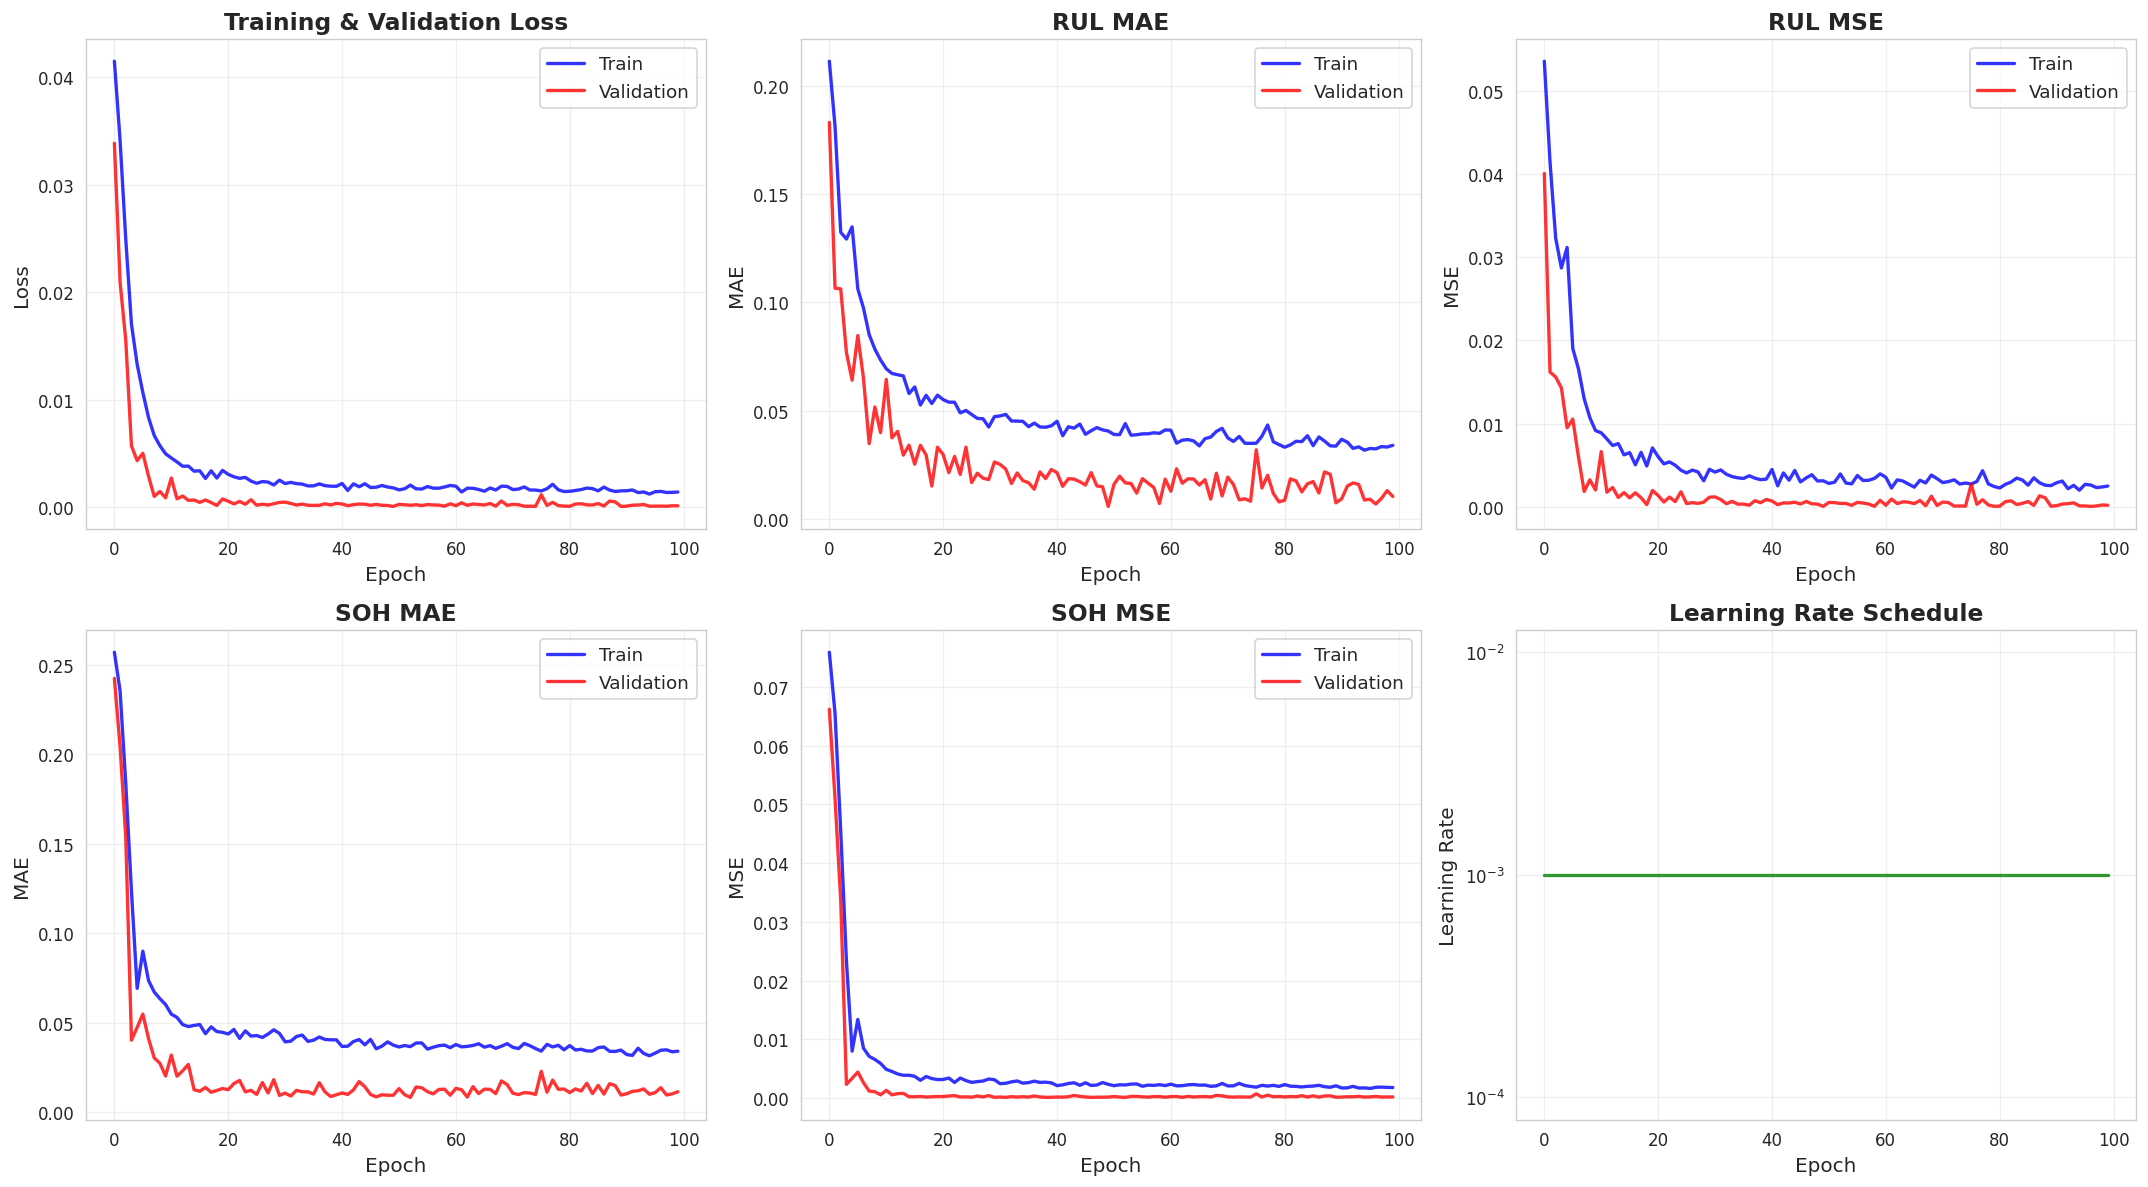

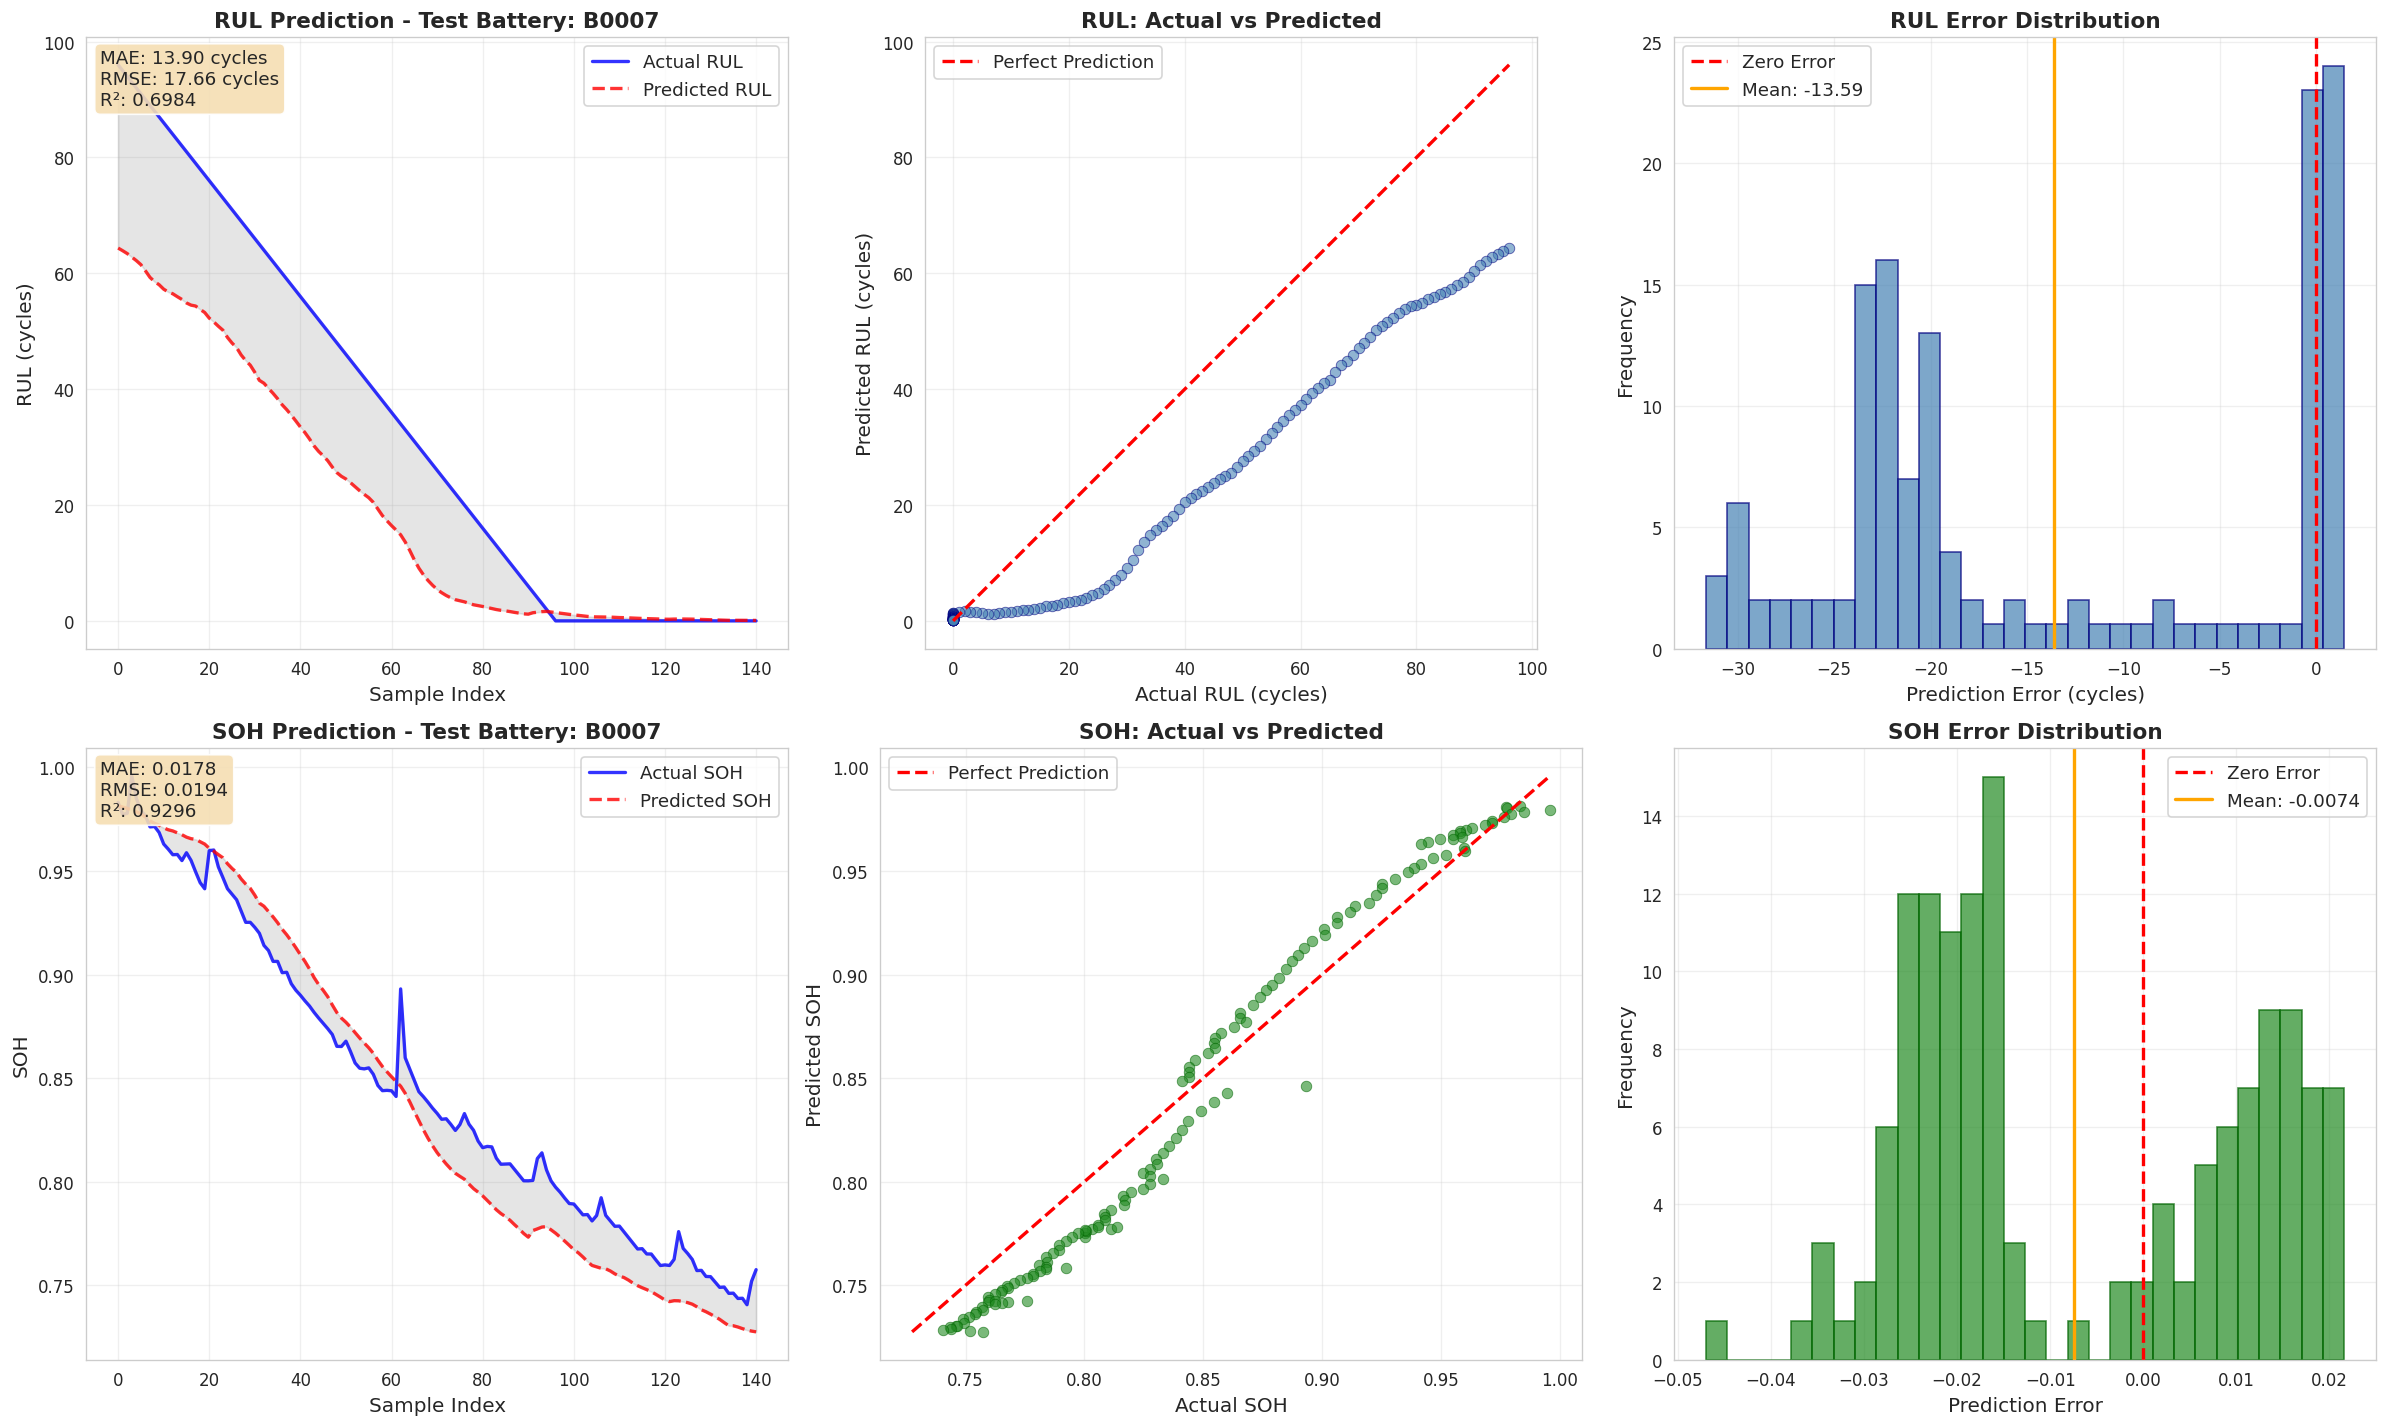

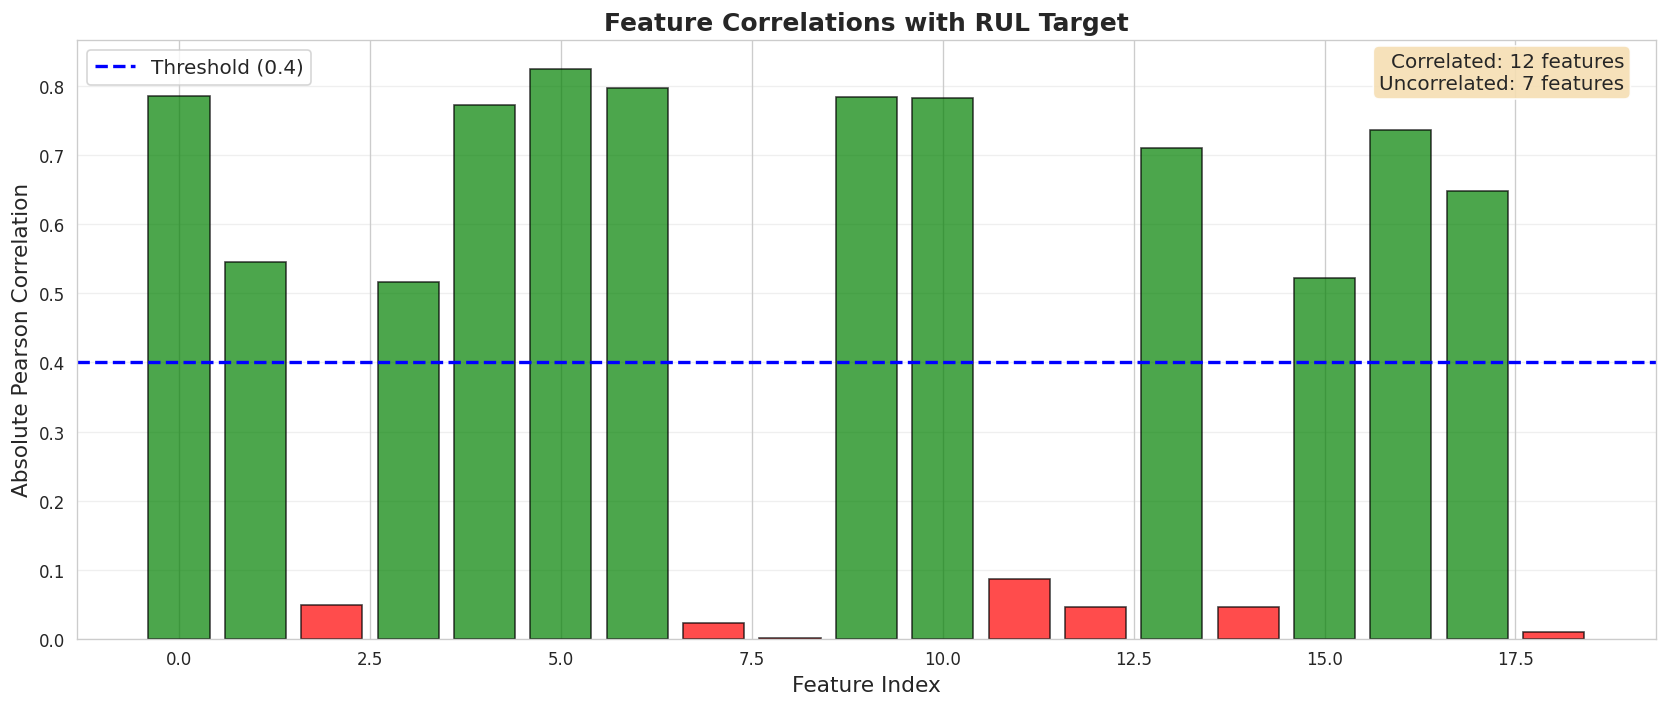


################################################################################
# EXPERIMENT: NASA_B5B7B18B6
# Test Battery: B0006
################################################################################

Preparing data for: NASA_B5B7B18B6
Train batteries: ['B0005', 'B0007', 'B0018']
Test battery: B0006

Loading train battery: B0005
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 100 cycles
  RUL range: [0.0, 73.0]
  SOH range: [0.693, 0.997]

Loading train battery: B0007
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 123 cycles
  RUL range: [0.0, 96.0]
  SOH range: [0.741, 0.996]

Loading train battery: B0018
  Cycles: 132, Sequences: 105, Features: 19
  EOL: 74 cycles
  RUL range: [0.0, 47.0]
  SOH range: [0.723, 0.931]

Total training sequences: 387

Loading test battery: B0006
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 60 cycles
  RUL range: [0.0, 33.0]
  SOH range: [0.567, 0.946]

Normalization completed:
  Max RUL for scaling: 96.0 cycles

Performing feat

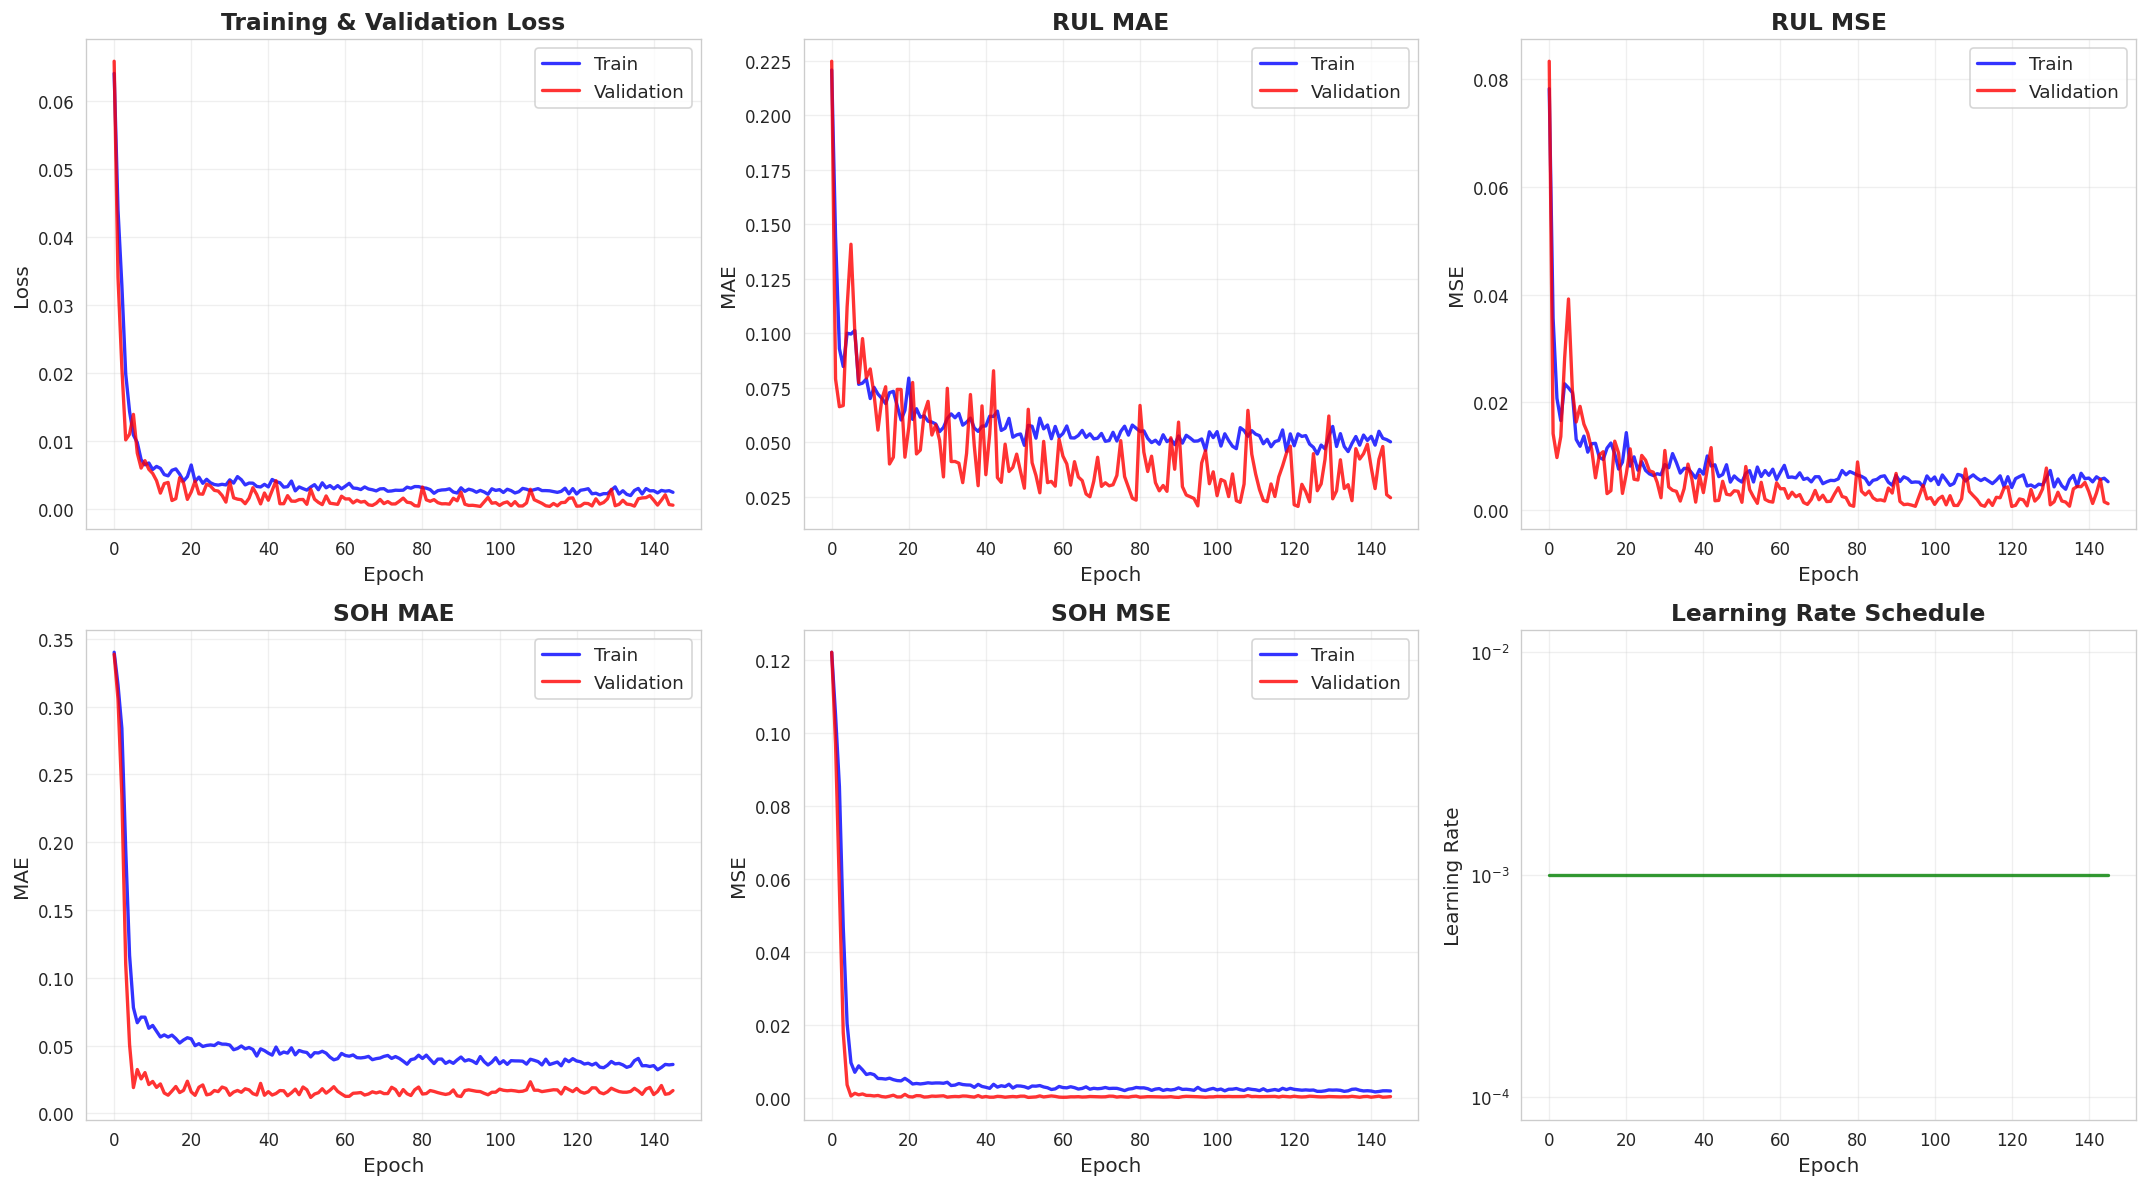

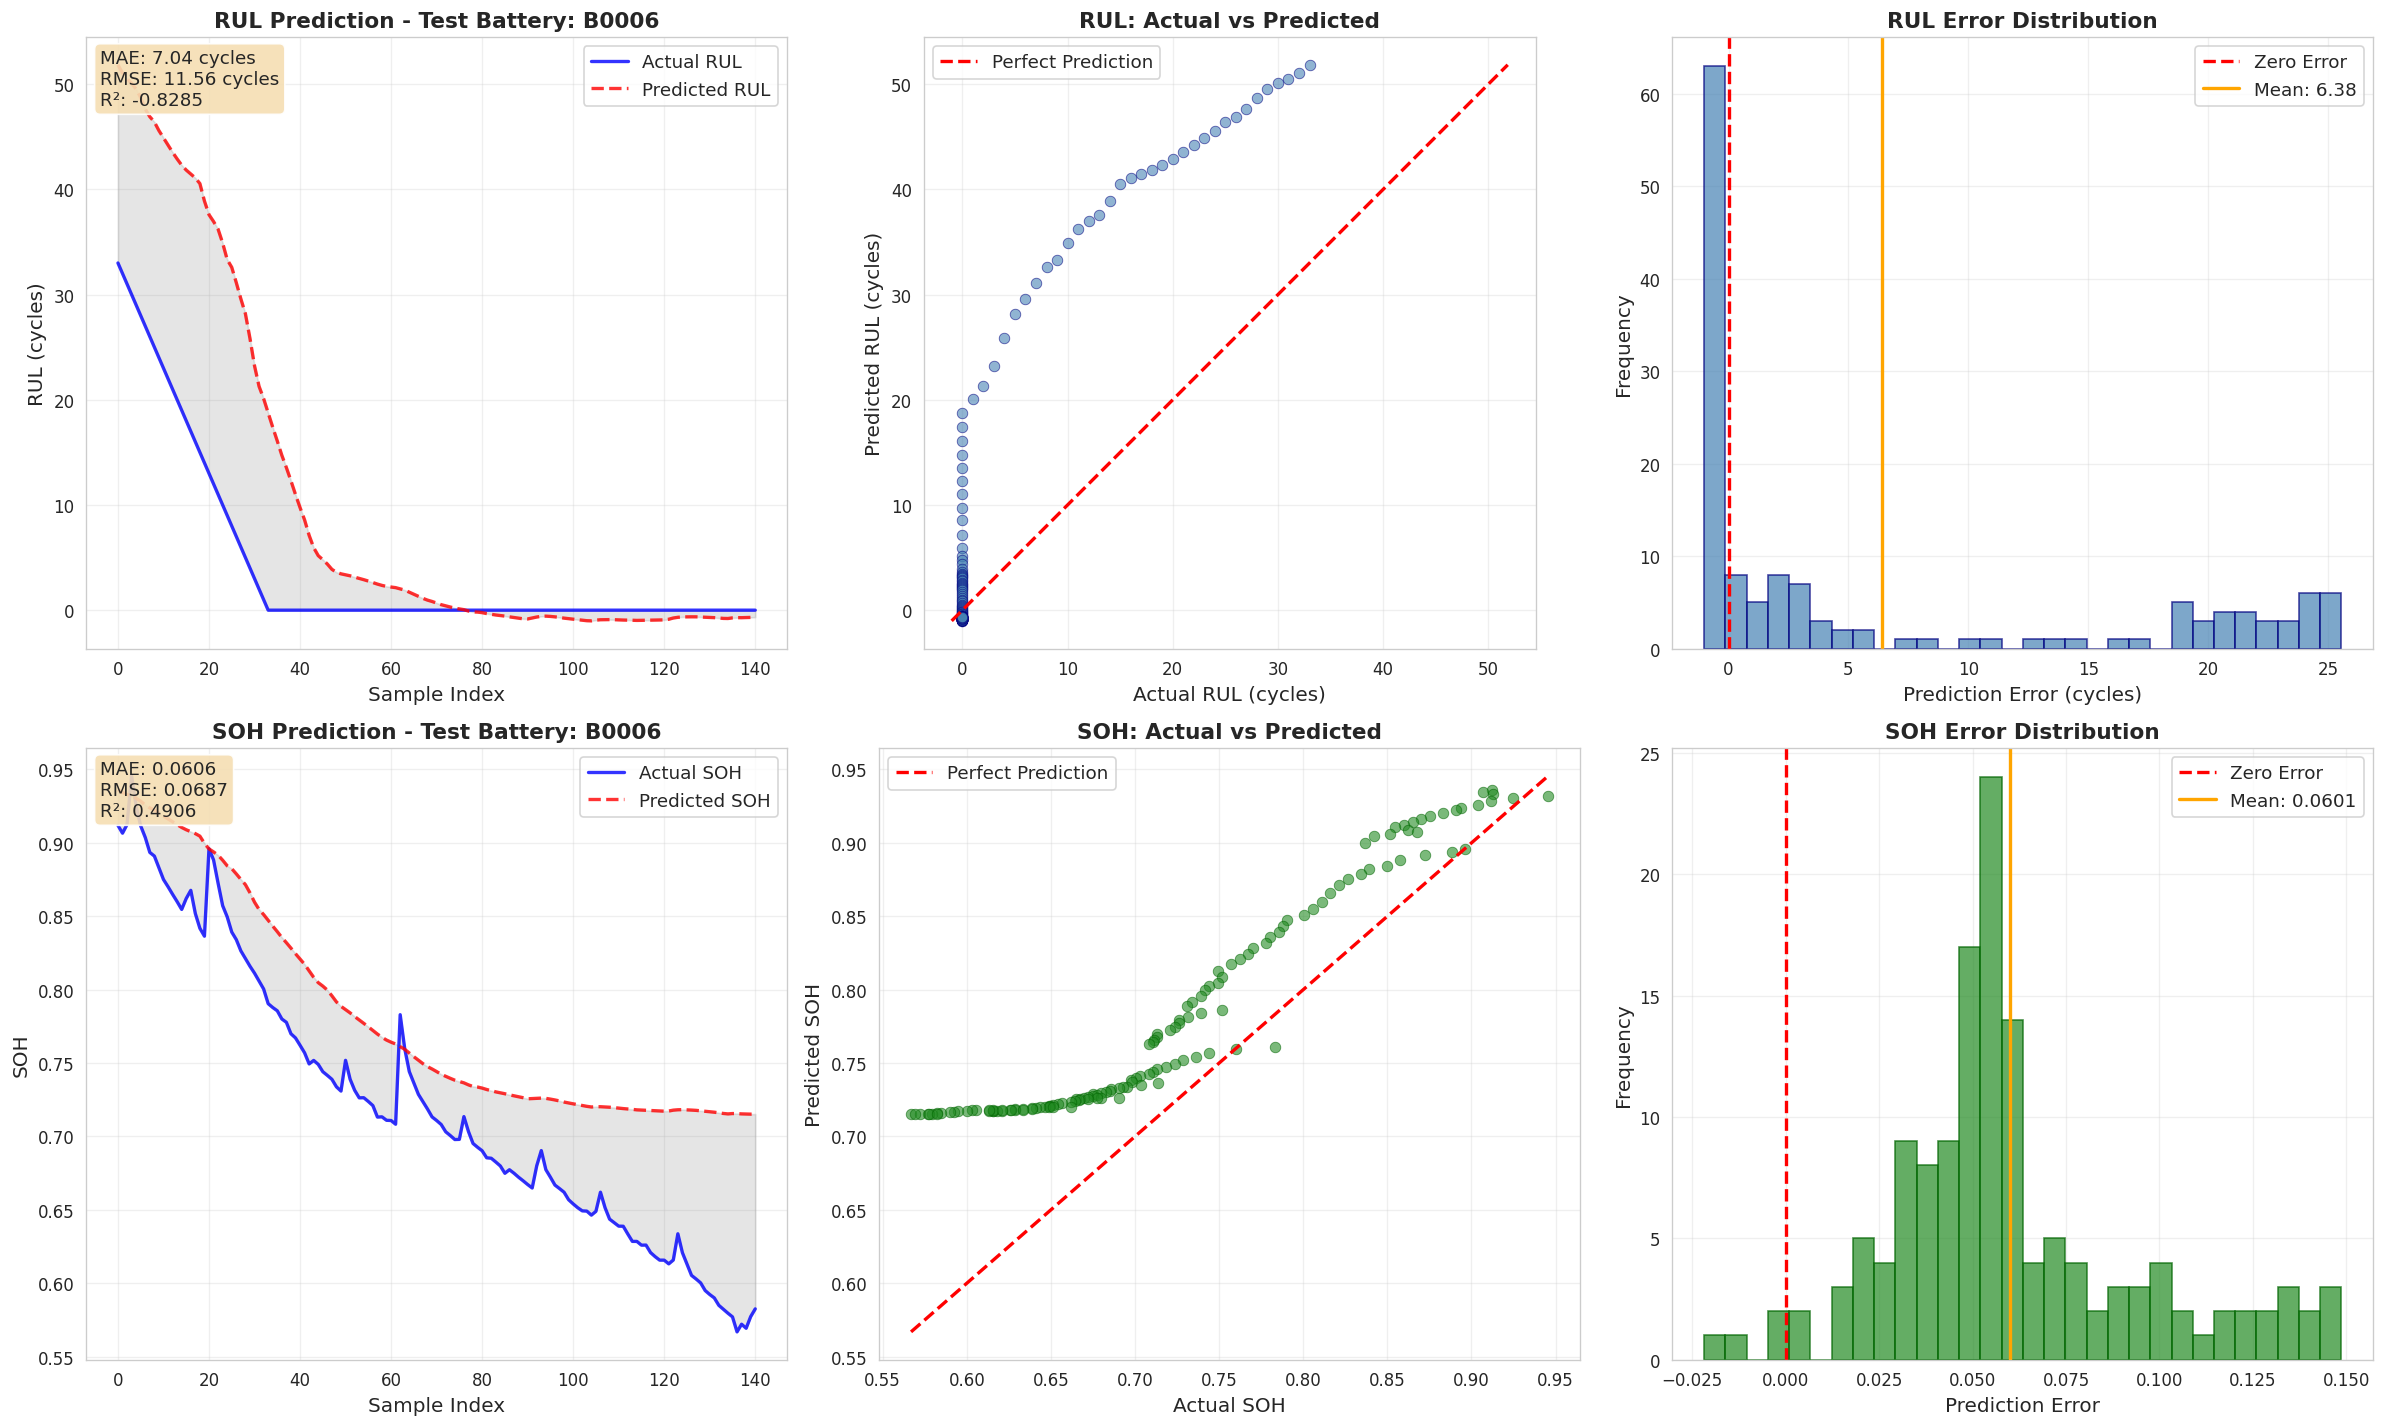

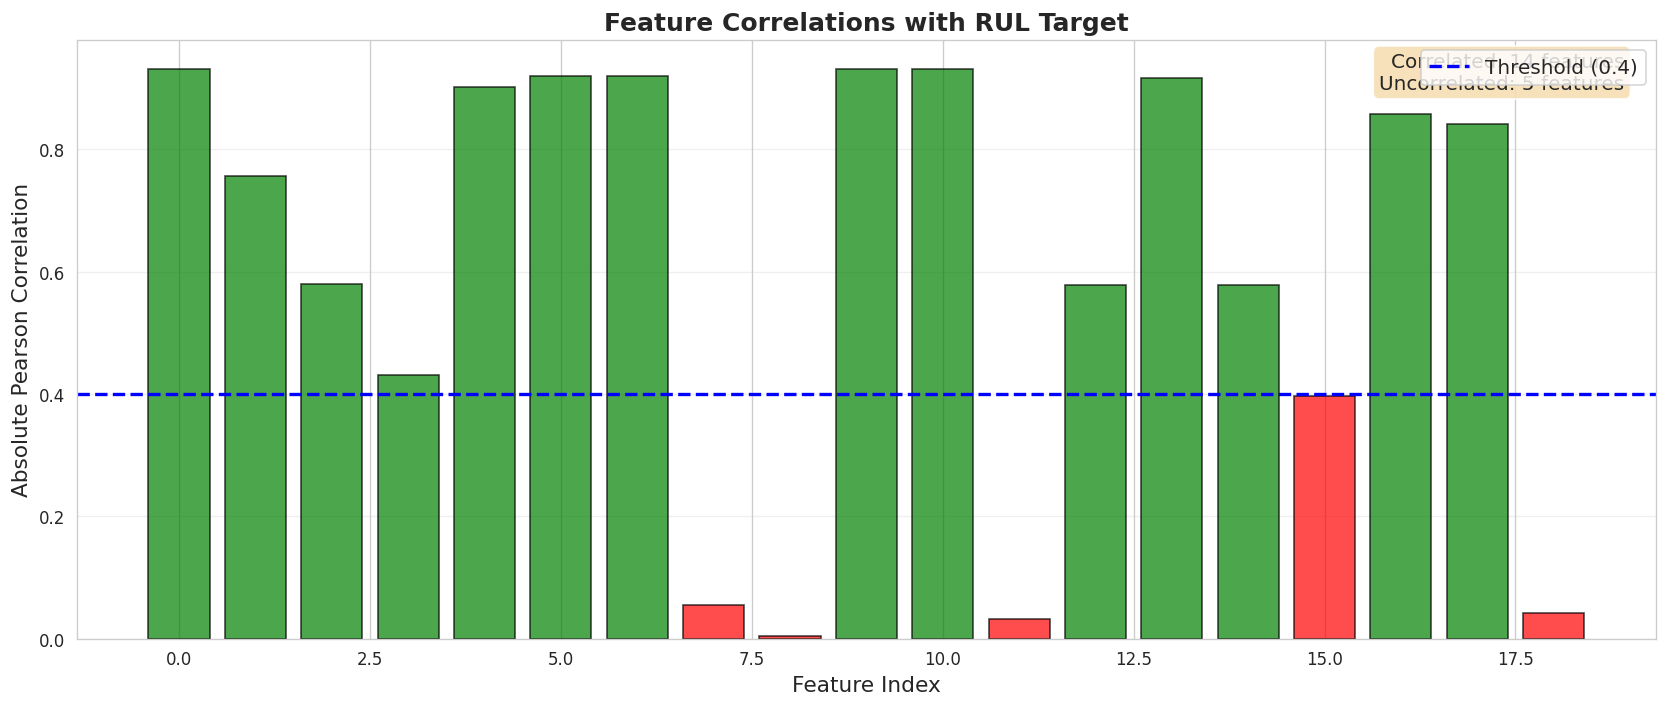


################################################################################
# EXPERIMENT: NASA_B6B7B18B5
# Test Battery: B0005
################################################################################

Preparing data for: NASA_B6B7B18B5
Train batteries: ['B0006', 'B0007', 'B0018']
Test battery: B0005

Loading train battery: B0006
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 60 cycles
  RUL range: [0.0, 33.0]
  SOH range: [0.567, 0.946]

Loading train battery: B0007
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 123 cycles
  RUL range: [0.0, 96.0]
  SOH range: [0.741, 0.996]

Loading train battery: B0018
  Cycles: 132, Sequences: 105, Features: 19
  EOL: 74 cycles
  RUL range: [0.0, 47.0]
  SOH range: [0.723, 0.931]

Total training sequences: 387

Loading test battery: B0005
  Cycles: 168, Sequences: 141, Features: 19
  EOL: 100 cycles
  RUL range: [0.0, 73.0]
  SOH range: [0.693, 0.997]

Normalization completed:
  Max RUL for scaling: 96.0 cycles

Performing feat

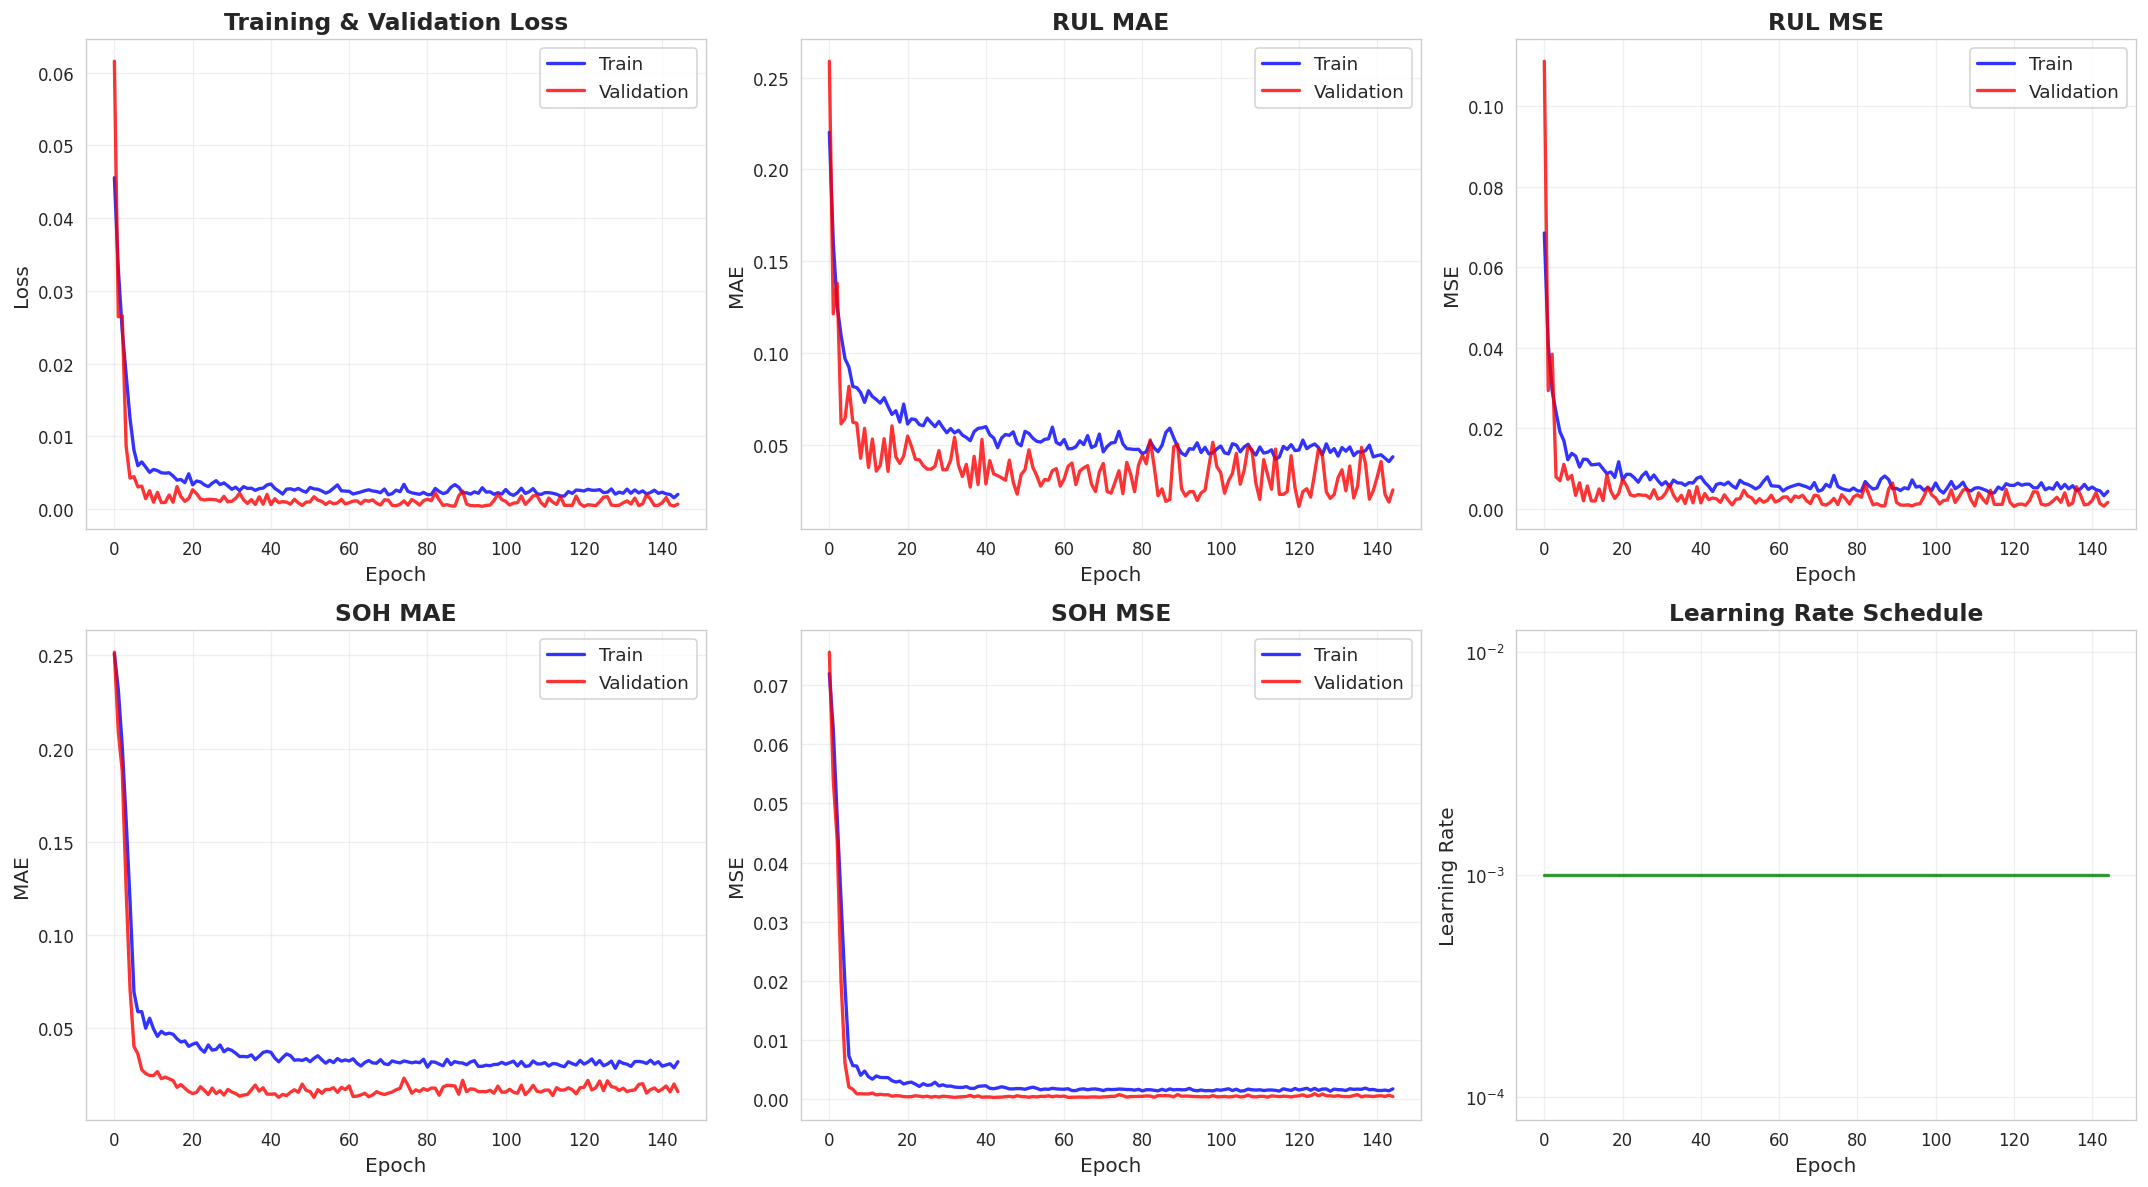

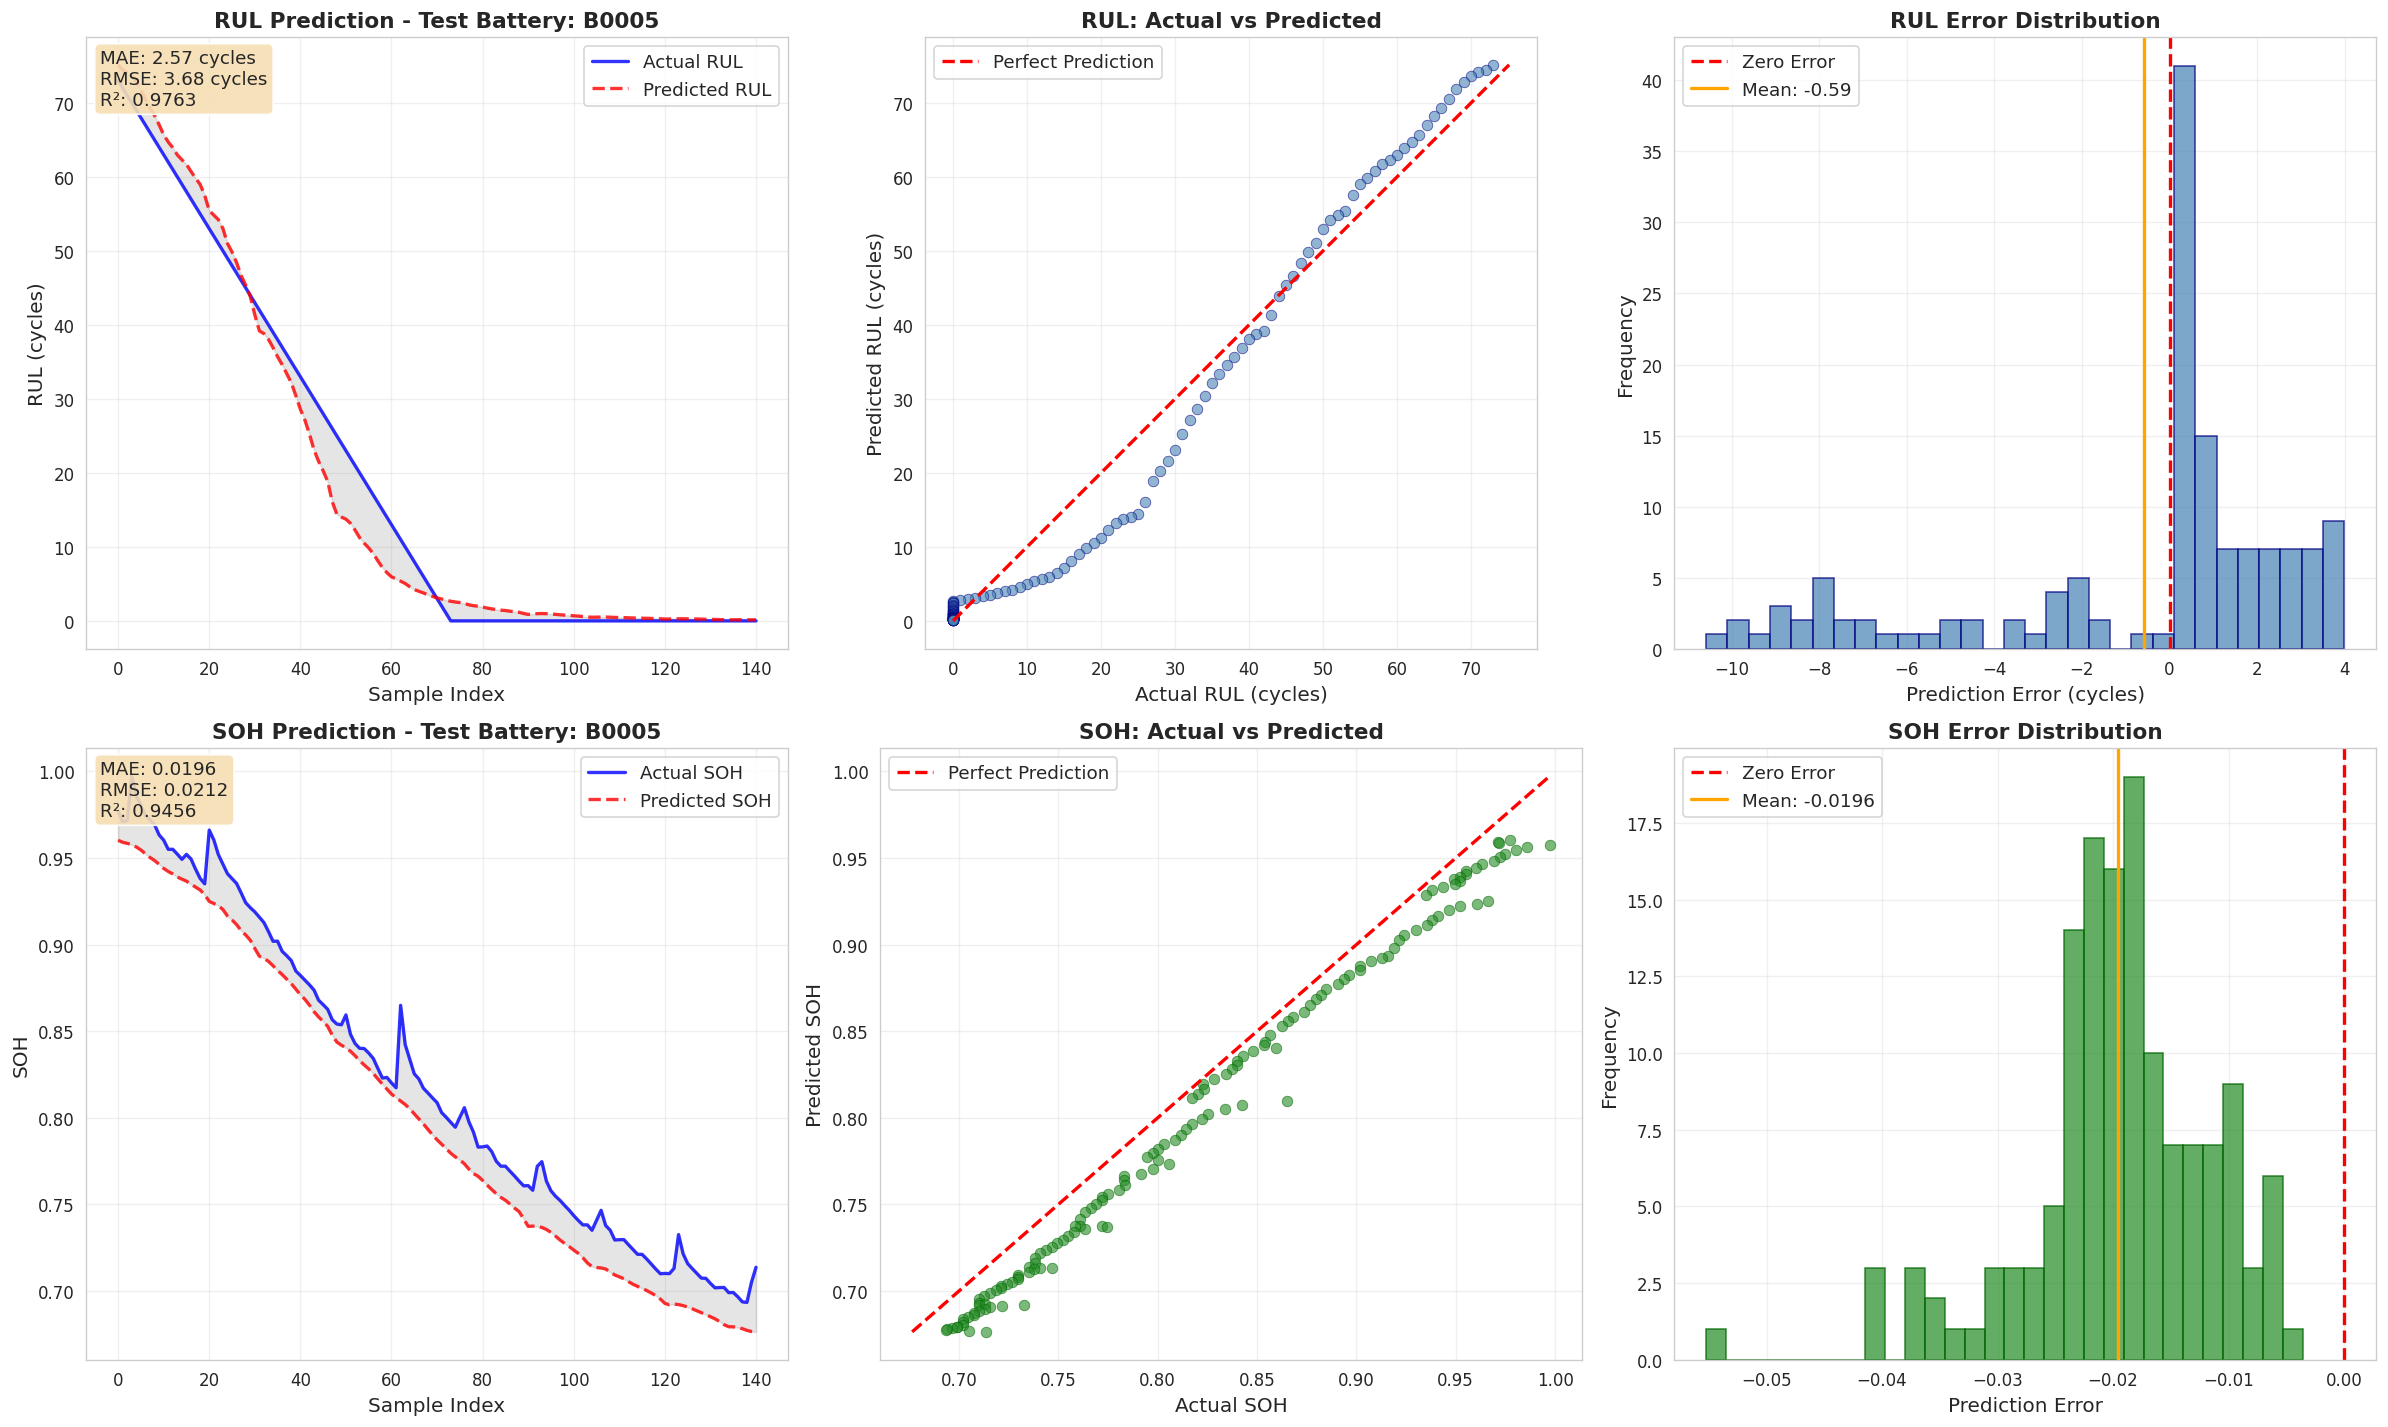

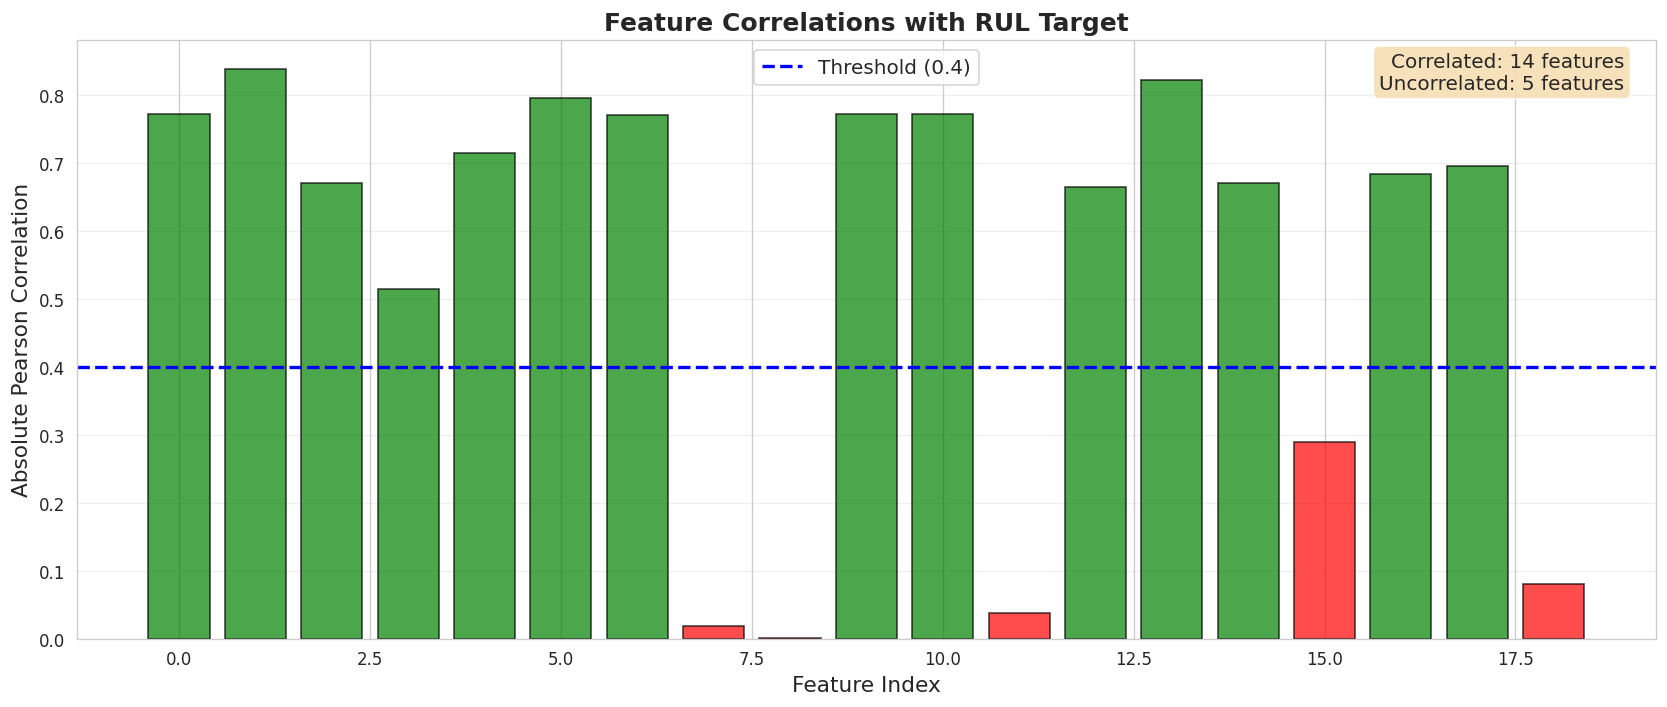


GENERATING COMPARISON PLOTS

Results table saved to: /content/drive/MyDrive/GRU_MHA_Results/comparison_table.csv


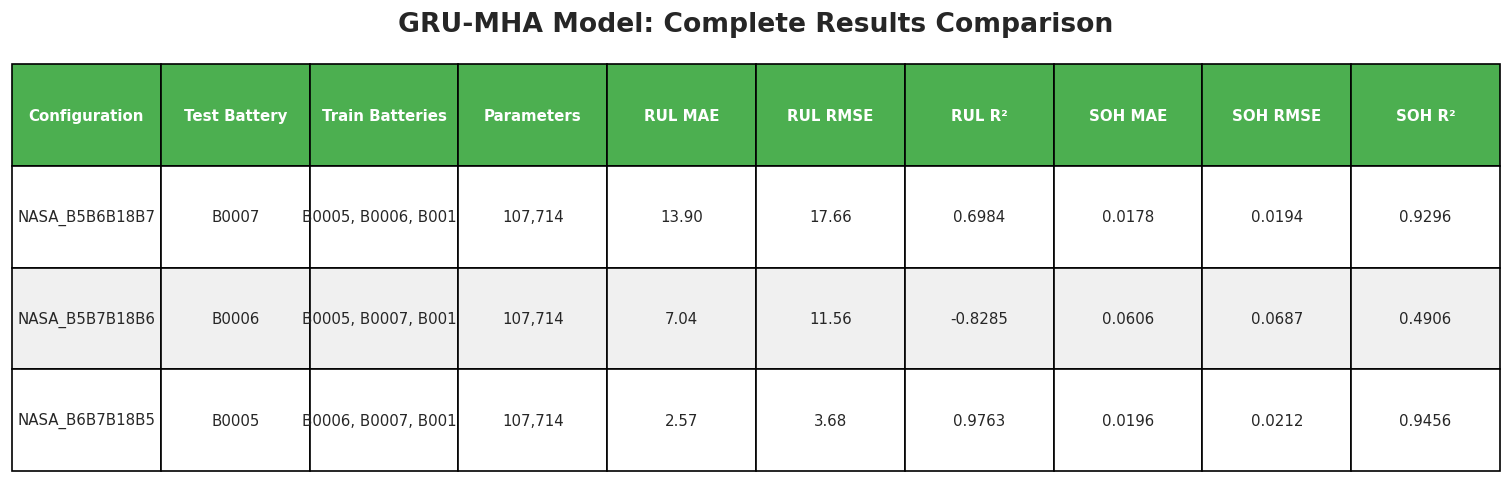


EXPERIMENT SUMMARY
 Configuration Test Battery     Train Batteries Parameters RUL MAE RUL RMSE  RUL R² SOH MAE SOH RMSE SOH R²
NASA_B5B6B18B7        B0007 B0005, B0006, B0018    107,714   13.90    17.66  0.6984  0.0178   0.0194 0.9296
NASA_B5B7B18B6        B0006 B0005, B0007, B0018    107,714    7.04    11.56 -0.8285  0.0606   0.0687 0.4906
NASA_B6B7B18B5        B0005 B0006, B0007, B0018    107,714    2.57     3.68  0.9763  0.0196   0.0212 0.9456

BEST MODELS

Best RUL Prediction:
  Configuration: NASA_B6B7B18B5
  Test Battery: B0005
  MAE: 2.57 cycles
  RMSE: 3.68 cycles
  R²: 0.9763

Best SOH Prediction:
  Configuration: NASA_B5B6B18B7
  Test Battery: B0007
  MAE: 0.0178
  RMSE: 0.0194
  R²: 0.9296

################################################################################
# COMPLETED in 6.8 minutes
# Total experiments: 3
# Results saved to: /content/drive/MyDrive/GRU_MHA_Results
################################################################################



In [27]:
main()

# Task
To resolve the `FileNotFoundError`, let's check the contents of your `DATASET_ROOT` directory: `/content/drive/MyDrive/NASA dataset`. This will help us confirm the correct path and structure of your NASA battery dataset.

## Verify Dataset Path

### Subtask:
Check the `DATASET_ROOT` variable in the `Config` class to ensure it points to the correct root directory where your NASA battery dataset is located.


**Reasoning**:
To verify the current configuration, I will print the value of `config.DATASET_ROOT` from the `Config` class.

